# Setup

In [1]:
print('Installing torchquantum...')
!git clone https://github.com/mit-han-lab/torchquantum.git
%cd /content/torchquantum
!pip install --editable . 1>/dev/null
# print('All required packages have been successfully installed!')

Installing torchquantum...
Cloning into 'torchquantum'...
remote: Enumerating objects: 11812, done.
remote: Counting objects: 100% (702/702), done.
remote: Compressing objects: 100% (284/284), done.
remote: Total 11812 (delta 421), reused 678 (delta 403), pack-reused 11110
Receiving objects: 100% (11812/11812), 6.75 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (6578/6578), done.
/content/torchquantum


In [2]:
!pip install tensorflow_model_optimization . 1>/dev/null
!ls artifact
!cp artifact/aerbackend.py ../../usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/backends/ -r
!wget https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
!pip install matplotlib==3.1.3 1>/dev/null
%matplotlib inline

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
aerbackend.py  example2  example4  example6  README.md
example1       example3  example5  example7
--2022-09-19 00:32:38--  https://www.dropbox.com/s/pvoqeab2z2cazke/max-acc-valid.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/pvoqeab2z2cazke/max-acc-valid.pt [following]
--2022-09-19 00:32:38--  https://www.dropbox.com/s/raw/pvoqeab2z2cazke/max-acc-valid.pt
Reusing existing connection to www.dropbox.com:443.


# **2. Usa TorchQuantum on the gate level**

## 2.1 QuantumNAS: Circuit Search and Pruning

 **Goals**

In this sectio you will practice searching an optimal subcircuit from a supercircuit and pruning the searched subcircuit to reduce the impact of noise and improve accuracy on real Quantum Computer. The goals of this assignment are as follows:

- Understand the basic concept of **supercircuit** and **subcircuit**
- Implement and apply **Evolutionary Search**
- Implement and apply **Pruning**
- Get a basic understanding of performance improvement (such as accuracy) from **Evolutionary Search** and **Pruning**

In [3]:
import argparse
import os
import sys
import pdb
import numpy as np
import torch
import torch.backends.cudnn
import torch.cuda
import torch.nn
import torch.utils.data
import torchquantum as tq
import tqdm
import random

from torchpack.utils import io
# from torchpack import distributed as dist
from torchpack.environ import set_run_dir
from torchpack.utils.config import configs
from torchpack.utils.logging import logger
from torchquantum.datasets import MNIST

from torchquantum.plugins import tq2qiskit, qiskit2tq
from torchquantum.utils import (build_module_from_op_list,
                                build_module_op_list,
                                get_v_c_reg_mapping,
                                get_p_c_reg_mapping,
                                get_p_v_reg_mapping,
                                get_cared_configs)
from torchquantum.super_utils import get_named_sample_arch
from torch.utils.tensorboard import SummaryWriter

In [4]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import torch.nn.functional as F

from torchpack.utils.logging import logger
from torchquantum.encoding import encoder_op_list_name_dict
from torchquantum.super_layers import super_layer_name_dict


class SuperQFCModel0(tq.QuantumModule):
    def __init__(self, arch):
        super().__init__()
        self.arch = arch
        self.n_wires = arch['n_wires']
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            encoder_op_list_name_dict[arch['encoder_op_list_name']]
        )
        self.q_layer = super_layer_name_dict[arch['q_layer_name']](arch)
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.sample_arch = None

    def set_sample_arch(self, sample_arch):
        self.sample_arch = sample_arch
        self.q_layer.set_sample_arch(sample_arch)

    def count_sample_params(self):
        return self.q_layer.count_sample_params()

    def forward(self, x, verbose=False, use_qiskit=False):
        bsz = x.shape[0]

        if getattr(self.arch, 'down_sample_kernel_size', None) is not None:
            x = F.avg_pool2d(x, self.arch['down_sample_kernel_size'])

        x = x.view(bsz, -1)

        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(self.q_device, x)
            self.q_layer(self.q_device)
            x = self.measure(self.q_device)

        if verbose:
            logger.info(f"[use_qiskit]={use_qiskit}, expectation:\n {x.data}")

        if getattr(self.arch, 'output_len', None) is not None:
            x = x.reshape(bsz, -1, self.arch.output_len).sum(-1)

        if x.dim() > 2:
            x = x.squeeze()

        x = F.log_softmax(x, dim=1)
        return x

    @property
    def arch_space(self):
        space = []
        for layer in self.q_layer.super_layers_all:
            space.append(layer.arch_space)
        # for the number of sampled blocks
        space.append(list(range(self.q_layer.n_front_share_blocks,
                                self.q_layer.n_blocks + 1)))
        return space


**Load configs**

The config file describes everything about the model structure.

In [5]:
config_str = '''model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False

dataset:
  name: mnist
  input_name: image
  target_name: digit

optimizer:
  name: adam
  lr: 5e-2
  weight_decay: 1e-4
  lambda_lr: 1e-2

run:
  n_epochs: 40
  bsz: 256
  workers_per_gpu: 2
  device: gpu

debug:
  pdb: False
  set_seed: True
  seed: 42

callbacks:
  - callback: 'InferenceRunner'
    split: 'valid'
    subcallbacks:
      - metrics: 'CategoricalAccuracy'
        name: 'acc/valid'
      - metrics: 'NLLError'
        name: 'loss/valid'
  - callback: 'InferenceRunner'
    split: 'test'
    subcallbacks:
      - metrics: 'CategoricalAccuracy'
        name: 'acc/test'
      - metrics: 'NLLError'
        name: 'loss/test'
  - callback: 'MaxSaver'
    name: 'acc/valid'
  - callback: 'Saver'
    max_to_keep: 10

qiskit:
  use_qiskit: False
  use_real_qc: False
  backend_name: null
  noise_model_name: null
  basis_gates_name: null
  n_shots: 8192
  initial_layout: null
  seed_transpiler: 42
  seed_simulator: 42
  optimization_level: 0
  est_success_rate: False
  max_jobs: 1


es:
  random_search: False
  population_size: 100
  parent_size: 20
  mutation_size: 40
  mutation_prob: 0.5
  crossover_size: 40
  n_iterations: 5
  est_success_rate: False
  score_mode: loss_succ
  gene_mask: null
  eval:
    use_noise_model: False
    use_real_qc: False
    bsz: qiskit_max
    n_test_samples: 150


prune:
  target_pruning_amount : 0.5
  init_pruning_amount : 0.1
  start_epoch : 0
  end_epoch : 30

'''
f = open("configs.yml", "w")
f.write(config_str)
f.close()

In [6]:
configs.load('configs.yml')
if configs.debug.set_seed:
    torch.manual_seed(configs.debug.seed)
    np.random.seed(configs.debug.seed)

Load the model.

In [7]:
device = torch.device('cuda')
if isinstance(configs.optimizer.lr, str):
    configs.optimizer.lr = eval(configs.optimizer.lr)
dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=[0, 1, 2, 3],
    n_test_samples=300,
    n_train_samples=5000,
    n_valid_samples=3000,
)
dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=configs.run.bsz,
        sampler=sampler,
        num_workers=configs.run.workers_per_gpu,
        pin_memory=True)
model = SuperQFCModel0(configs.model.arch)
state_dict = io.load('max-acc-valid.pt', map_location='cpu')
model.load_state_dict(state_dict['model'], strict=False)
model.to(device)
model.set_sample_arch([4,4,4,4,4,4,3])
total_params = sum(p.numel() for p in model.parameters())
logger.info(f'Model Size: {total_params}')

def log_acc(output_all, target_all, k=1):
    _, indices = output_all.topk(k, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()
    logger.info(f"Accuracy: {accuracy}")
    logger.info(f"Loss: {loss}")
    return accuracy

def evaluate_gene(gene=None, use_qiskit=False):
    if gene is not None:
        model.set_sample_arch(gene)
    with torch.no_grad():
        target_all = None
        output_all = None
        for feed_dict in tqdm.tqdm(dataflow['test']):
            if configs.run.device == 'gpu':
                # pdb.set_trace()
                inputs = feed_dict[configs.dataset.input_name].cuda(non_blocking=True)
                targets = feed_dict[configs.dataset.target_name].cuda(non_blocking=True)
            else:
                inputs = feed_dict[configs.dataset.input_name]
                targets = feed_dict[configs.dataset.target_name]
            outputs = model(inputs, use_qiskit=use_qiskit)
            if target_all is None:
                target_all = targets
                output_all = outputs
            else:
                target_all = torch.cat([target_all, targets], dim=0)
                output_all = torch.cat([output_all, outputs], dim=0)
        accuracy = log_acc(output_all, target_all)
    return accuracy

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



[2022-09-19 00:33:09.081] Only use the front 5000 images as TRAIN set.
[2022-09-19 00:33:09.141] Only use the front 3000 images as VALID set.
[2022-09-19 00:33:09.157] Only use the front 300 images as TEST set.
[2022-09-19 00:33:13.333] Model Size: 72


**Let's use the model to predict MNIST images**

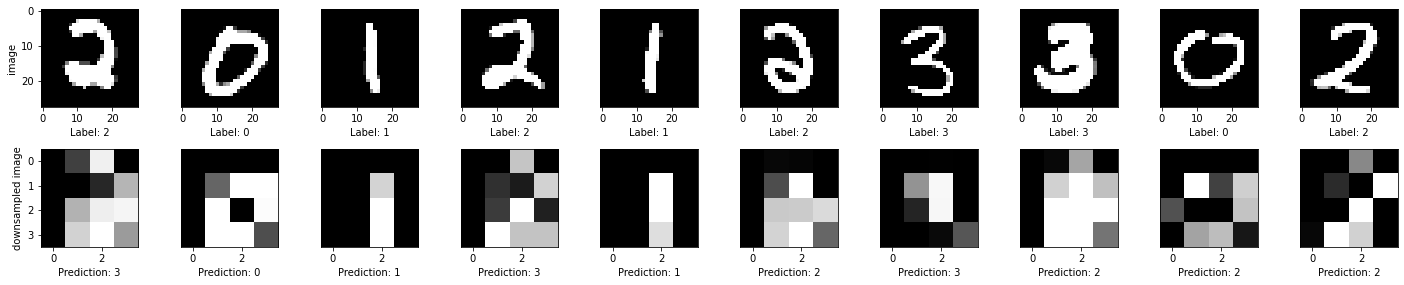

In [8]:

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
n_samples = 10
for feed_dict in dataflow['test']:
  inputs = feed_dict['image']
  outputs = feed_dict['digit']
  break
images = inputs[:n_samples]
# Down sample the image from 28x28 to 4x4.
# This down sampled image is the circuit input.
after_down_sample = F.avg_pool2d(images, 6)

# Forward the model to get prediction.
pred = model(images)
_, indices = pred.topk(1, dim=1)

# Plot 10 samples with label and prediction.
fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
for k in range(n_samples):
    axes[0, 0].set_ylabel("image")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].set_xlabel("Label: {0}".format(outputs[k]))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    axes[0, k].imshow(images[k, 0, :, :].cpu(), norm=norm, cmap="gray")

    axes[1, 0].set_ylabel("downsampled image")
    if k != 0:
        axes[1, k].yaxis.set_visible(False)
    axes[1, k].set_xlabel("Prediction: {0}".format(indices[k][0]))
    axes[1, k].imshow(after_down_sample[k, 0, :, :], norm=norm, cmap="gray")

plt.tight_layout()
plt.show()


**Supercircuit and  Subcircuit**

We constructed a SuperCircuit by stacking a sufficient number of layers of pre-defined parameterized gates to cover a large *design space*. Then, we have already trained the SuperCircuit by sampling and updating the parameter subsets (SubCircuits) from the SuperCircuit. The performance of a SubCircuit with inherited parameters from the SuperCircuit can provide a reliable relative performance estimation for the individual SubCircuit trained from scratch. In this way, we only pay the training cost once but can evaluate all the SubCircuits fast and efficiently. Hence, the search cost is significantly reduced. 

In this supercircuit, there are totally 3 blocks and 2 layers(a U3 layer and a CU3 layer) in each block. The gene (Which covers all *design space*) length is 7. The front 6 positions mean how many front gates we put in the circuit in kth layer. The last position of gene means how many front blocks we put in the circuit.


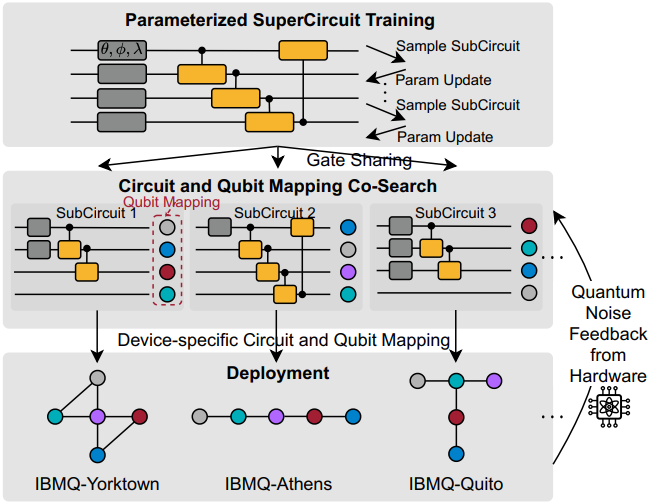


In the following code cell we randomly sample a subcircuit to further show the relation between the subcircuit's architecture and its gene for you to understand.


Sampled gene: [3, 3, 1, 2, 1, 1, 3]
Circuit depth: 6
Architecture:


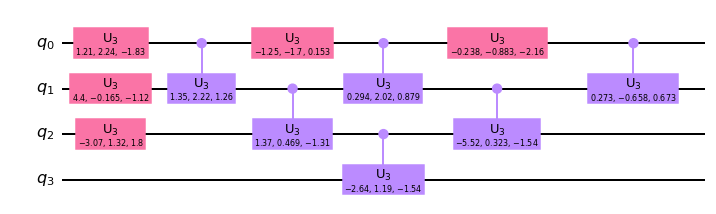

In [9]:
from torchquantum.plugins import tq2qiskit
gene_choice = model.arch_space
gene_len = len(gene_choice)
n_samples=1
samp_gene = []
for k in range(gene_len):
    samp_gene.append(random.choices(gene_choice[k])[0])
print("Sampled gene: " + str(samp_gene))
model.set_sample_arch(samp_gene)
circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model.q_layer)
print("Circuit depth: {0}".format(circ.depth()))
print("Architecture:")
circ.draw('mpl')

**Different performance between noise-free simulator and noisy simulator**
On real quantum computers, noise can distort the output of the circuit. In this subsection we will show the accuracy gap brought by noise. We use qiskit's noisy simulator to simulate the noisy environment on real quantum computers.

First, we setup a noisy simulator, **specify the *qubit mapping (layout)*** and attach it to our model.

In [11]:
from torchquantum.plugins import QiskitProcessor
from qiskit import IBMQ
IBMQ.save_account('0238b0afc0dc515fe7987b02706791d1719cb89b68befedc125eded0607e6e9e9f26d3eed482f66fdc45fdfceca3aab2edb9519d96b39e9c78040194b86e7858', overwrite=True)

processor_real_qc = QiskitProcessor(use_real_qc=False, noise_model_name = 'ibmq_quito', backend_name='ibmq_quito')

processor_real_qc.set_layout([0, 1, 2, 3]) # default layout: virtual qubit 0 for physical qubit 0, ..., virtual qubit 3 for physical qubit 3

model.set_qiskit_processor(processor_real_qc)

100%|██████████| 2/2 [00:00<00:00,  8.29it/s]
[2022-09-19 00:36:33.558] Accuracy: 0.49666666666666665
[2022-09-19 00:36:33.559] Loss: 1.2080743312835693
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:36:33.778] Before transpile: {'depth': 8, 'size': 25, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 2, 'measure': 4}}
[2022-09-19 00:36:33.887] After transpile: {'depth': 8, 'size': 25, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 2, 'measure': 4}}


Job Status: job has successfully run
Job Status: job is being initialized
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.43s/it][2022-09-19 00:36:44.065] Before transpile: {'depth': 8, 'size': 25, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 2, 'measure': 4}}
[2022-09-19 00:36:44.107] After transpile: {'depth': 8, 'size': 25, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 2, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.73s/it]
[2022-09-19 00:36:47.027] Accuracy: 0.49333333333333335
[2022-09-19 00:36:47.041] Loss: 1.2184091266935244
100%|██████████| 2/2 [00:00<00:00,  7.36it/s]
[2022-09-19 00:36:47.340] Accuracy: 0.5466666666666666
[2022-09-19 00:36:47.346] Loss: 1.1071999073028564
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:36:47.537] Before transpile: {'depth': 13, 'size': 33, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 6, 'measure': 4}}
[2022-09-19 00:36:47.577] After transpile: {'depth': 13, 'size': 33, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 6, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.56s/it][2022-09-19 00:36:56.926] Before transpile: {'depth': 13, 'size': 33, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 6, 'measure': 4}}
[2022-09-19 00:36:57.053] After transpile: {'depth': 13, 'size': 33, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 6, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.14s/it]
[2022-09-19 00:36:59.643] Accuracy: 0.5433333333333333
[2022-09-19 00:36:59.644] Loss: 1.125934737653964
100%|██████████| 2/2 [00:00<00:00,  6.15it/s]
[2022-09-19 00:36:59.980] Accuracy: 0.7133333333333334
[2022-09-19 00:36:59.983] Loss: 1.067213535308838
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:37:00.181] Before transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:37:00.227] After transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.87s/it][2022-09-19 00:37:09.873] Before transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:37:09.918] After transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.45s/it]
[2022-09-19 00:37:12.902] Accuracy: 0.72
[2022-09-19 00:37:12.903] Loss: 1.090604862178361


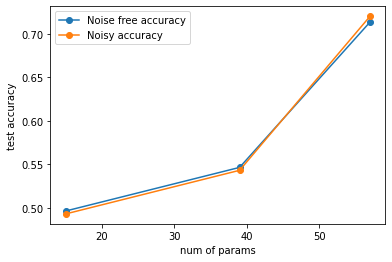

In [13]:
gene_list = [[3,2,4,4,2,4,1], [3,2,4,4,2,4,2], [3,2,4,4,2,4,3]]
param_num = []
accu_noise_free = []
accu_noisy_model = []
for gene in gene_list:
    total_params = 3 * sum(gene[k] for k in range(2 * gene[-1]))
    param_num.append(total_params)
    accu_noise_free.append(evaluate_gene(gene=gene, use_qiskit=False))
    accu_noisy_model.append(evaluate_gene(gene=gene, use_qiskit=True))

plt.plot(param_num, accu_noise_free, marker='o', label="Noise free accuracy")
plt.plot(param_num, accu_noisy_model, marker='o', label="Noisy accuracy")
plt.ylabel("test accuracy")
plt.xlabel("num of params")
plt.legend()
plt.show()

### Part 1: Search for the best gene

In order to find the best subcircuit in real quantum computer's noisy environment, we need the noisy simulator to search for the best gene.

####Part 1.1: Random Search



In [20]:
class RandomSearcher:
    def __init__(self, gene_choice, accuracy_predictor):
        self.gene_choice = gene_choice
        self.gene_len = len(self.gene_choice)
        self.accuracy_predictor = accuracy_predictor

    def random_sample(self, sample_num):
        # randomly sample genes
        population = []
        i = 0
        while i < sample_num:
            samp_gene = []
            for k in range(self.gene_len):
                samp_gene.append(random.choices(self.gene_choice[k])[0])
            population.append(samp_gene)
            i += 1

        return population

    def run_search(self, n_subcircuits=100):
        # sample subcircuits
        self.population = self.random_sample(n_subcircuits)
        # predict the accuracy of subnets
        accs = []
        for gene in self.population:
          accs.append(self.accuracy_predictor(gene=gene, use_qiskit=True))


        # get the index of the best subnet
        accs = np.array(accs)
        best_idx = accs.argmax()

        # return the best subnet
        return accs[best_idx], self.population[best_idx]

In [21]:
agent = RandomSearcher(model.arch_space, evaluate_gene)


# get the accuracy and gene of the best subcircuit
acc, gene = agent.run_search(10)

print(gene)
print(acc)

  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:51:17.861] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 3, 'measure': 4}}
[2022-09-19 00:51:17.893] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 3, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.23s/it][2022-09-19 00:51:27.927] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 3, 'measure': 4}}
[2022-09-19 00:51:27.958] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 3, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.69s/it]
[2022-09-19 00:51:31.060] Accuracy: 0.5233333333333333
[2022-09-19 00:51:31.062] Loss: 1.1178400952332603
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:51:31.268] Before transpile: {'depth': 12, 'size': 35, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:51:31.319] After transpile: {'depth': 12, 'size': 35, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 7, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:11<00:11, 11.07s/it][2022-09-19 00:51:42.162] Before transpile: {'depth': 12, 'size': 35, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:51:42.208] After transpile: {'depth': 12, 'size': 35, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 7, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:14<00:00,  7.23s/it]
[2022-09-19 00:51:45.537] Accuracy: 0.64
[2022-09-19 00:51:45.538] Loss: 1.0768679596464827
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:51:45.795] Before transpile: {'depth': 7, 'size': 24, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:51:45.828] After transpile: {'depth': 7, 'size': 24, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.17s/it][2022-09-19 00:51:55.749] Before transpile: {'depth': 7, 'size': 24, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:51:55.770] After transpile: {'depth': 7, 'size': 24, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.65s/it]
[2022-09-19 00:51:58.871] Accuracy: 0.5066666666666667
[2022-09-19 00:51:58.873] Loss: 1.2454881983522421
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:51:59.152] Before transpile: {'depth': 11, 'size': 27, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:51:59.176] After transpile: {'depth': 11, 'size': 27, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:11<00:11, 11.46s/it][2022-09-19 00:52:10.353] Before transpile: {'depth': 11, 'size': 27, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:52:10.376] After transpile: {'depth': 11, 'size': 27, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:14<00:00,  7.21s/it]
[2022-09-19 00:52:13.310] Accuracy: 0.49333333333333335
[2022-09-19 00:52:13.313] Loss: 1.2137750657866044
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:52:13.507] Before transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}
[2022-09-19 00:52:13.535] After transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.27s/it][2022-09-19 00:52:22.605] Before transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}
[2022-09-19 00:52:22.632] After transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.13s/it]
[2022-09-19 00:52:25.577] Accuracy: 0.49
[2022-09-19 00:52:25.580] Loss: 1.203591203062656
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:52:25.855] Before transpile: {'depth': 14, 'size': 32, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 6, 'measure': 4}}
[2022-09-19 00:52:25.891] After transpile: {'depth': 14, 'size': 32, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 6, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.16s/it][2022-09-19 00:52:35.762] Before transpile: {'depth': 14, 'size': 32, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 6, 'measure': 4}}
[2022-09-19 00:52:35.795] After transpile: {'depth': 14, 'size': 32, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 6, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 6, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.59s/it]
[2022-09-19 00:52:38.777] Accuracy: 0.43666666666666665
[2022-09-19 00:52:38.778] Loss: 1.2419370779175787
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:52:38.990] Before transpile: {'depth': 12, 'size': 30, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:52:39.019] After transpile: {'depth': 12, 'size': 30, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 7, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.65s/it][2022-09-19 00:52:48.457] Before transpile: {'depth': 12, 'size': 30, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:52:48.481] After transpile: {'depth': 12, 'size': 30, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 7, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.33s/it]
[2022-09-19 00:52:51.460] Accuracy: 0.6033333333333334
[2022-09-19 00:52:51.464] Loss: 1.1190118859257092
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:52:51.731] Before transpile: {'depth': 14, 'size': 33, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:52:51.772] After transpile: {'depth': 14, 'size': 33, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 7, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.76s/it][2022-09-19 00:53:02.242] Before transpile: {'depth': 14, 'size': 33, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:53:02.278] After transpile: {'depth': 14, 'size': 33, 'width': 8, 'n_single_gates': 22, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 6, 'cu3': 7, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.93s/it]
[2022-09-19 00:53:05.332] Accuracy: 0.6333333333333333
[2022-09-19 00:53:05.336] Loss: 1.1388151342143036
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:53:05.524] Before transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}
[2022-09-19 00:53:05.553] After transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.35s/it][2022-09-19 00:53:14.710] Before transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}
[2022-09-19 00:53:14.735] After transpile: {'depth': 8, 'size': 26, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 2, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 2, 'measure': 4}}


Job Status: job has successfully run
Job Status: job is being initialized
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.16s/it]
[2022-09-19 00:53:17.673] Accuracy: 0.48
[2022-09-19 00:53:17.676] Loss: 1.2040349949356608
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:53:17.874] Before transpile: {'depth': 12, 'size': 28, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 5, 'measure': 4}}
[2022-09-19 00:53:17.902] After transpile: {'depth': 12, 'size': 28, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 5, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.53s/it][2022-09-19 00:53:27.236] Before transpile: {'depth': 12, 'size': 28, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 5, 'measure': 4}}
[2022-09-19 00:53:27.331] After transpile: {'depth': 12, 'size': 28, 'width': 8, 'n_single_gates': 19, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 3, 'cu3': 5, 'measure': 4}}


Job Status: job has successfully run
Job Status: job is being initialized
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.26s/it]
[2022-09-19 00:53:30.222] Accuracy: 0.5466666666666666
[2022-09-19 00:53:30.226] Loss: 1.124545208780707


[4, 3, 1, 3, 3, 1, 3]
0.64


####Part 1.2 Evolutionary Search


**Evolutionary Search**
In this part, we will implement a more sample-efficient search algorithm, evolutionary search. Evolutionary search is inspired by the evolution algorithm (or genetic algorithm). A **population** of sub-networks are first sampled from the design space. Then, in each **generation**, we perform random mutation and crossover operations as is shown in the figure above. The sub-networks with highest accuracy will be kept, and this process will be repeated until the number of generations reaches `max_time_budget`. Similar to the random search, throughout the search process, all sub-networks that cannot satisfy the efficiency constraint will be discarded.


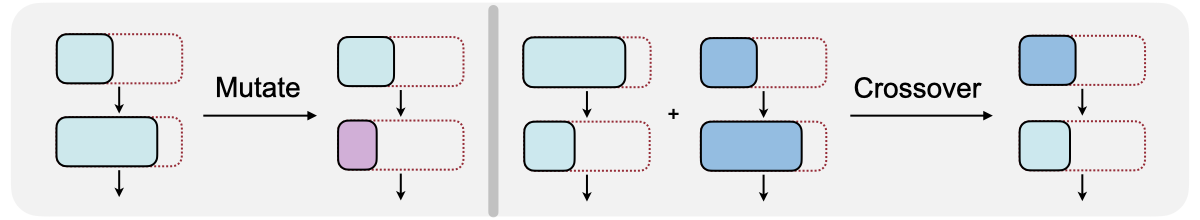

In [15]:
class EvolutionarySearcher:
    def __init__(self,
                 gene_choice,
                 accuracy_predictor,
                 configs):
        self.gene_choice = gene_choice
        self.gene_len = len(self.gene_choice)
        self.accuracy_predictor = accuracy_predictor
        self.n_iterations = configs.es.n_iterations
        self.parent_size = 2 #configs.es.parent_size
        self.mutation_size = 4 #configs.es.mutation_size
        self.mutation_prob = configs.es.mutation_prob
        self.crossover_size = 4 #configs.es.crossover_size

    def random_sample(self, sample_num):
        # randomly sample genes
        population = []
        i = 0
        while i < sample_num:
            samp_gene = []
            for k in range(self.gene_len):
                samp_gene.append(random.choices(self.gene_choice[k])[0])
            population.append(samp_gene)
            i += 1
        return population

    def ask(self):
        """return the solutions"""
        return self.population

    def select_and_transform(self, scores):
        """perform evo search according to the scores"""
        
        # sort the index according to the scores (descending order)
        sorted_idx = (-np.array(scores)).argsort()[:self.parent_size]

        # hint: update self.best_solution and self.best_score
        self.best_solution = self.population[sorted_idx[0]]
        self.best_score = scores[sorted_idx[0]]

        parents = [self.population[i] for i in sorted_idx]

        # mutation
        mutate_population = []
        k = 0
        while k < self.mutation_size:
            mutated_gene = self.mutate(random.choices(parents)[0])
            mutate_population.append(mutated_gene)
            k += 1

        # crossover
        crossover_population = []
        k = 0
        while k < self.crossover_size:
            crossovered_gene = self.crossover(random.sample(parents, 2))
            crossover_population.append(crossovered_gene)
            k += 1

        self.population = parents + mutate_population + crossover_population

    def crossover(self, genes):
        crossovered_gene = []
        for i in range(self.gene_len):
            if np.random.uniform() < 0.5:
                crossovered_gene.append(genes[0][i])
            else:
                crossovered_gene.append(genes[1][i])
        return crossovered_gene

    def mutate(self, gene):
        mutated_gene = []
        for i in range(self.gene_len):        
            # use np.random.uniform() to decide whether to mutate position i
            # mutate ith position of gene with self.mutation_prob as mutation probability
            if np.random.uniform() < self.mutation_prob:
                mutated_gene.append(random.choices(self.gene_choice[i])[0])
            else:
                mutated_gene.append(gene[i])
        return mutated_gene
    
    def run_search(self):
        # sample subcircuits
        self.population = self.random_sample(self.parent_size + self.mutation_size + self.crossover_size)
        for i in range(self.n_iterations):
            # predict the accuracy of subnets
            accs = []
            for gene in self.population:
                accs.append(self.accuracy_predictor(gene=gene, use_qiskit=True))
            self.select_and_transform(accs)
            logger.info(f"Best solution: {self.best_solution}")
            logger.info(f"Best score: {self.best_score}")
        # return the best subnet
        return self.best_score, self.best_solution

In [18]:
agent2.n_iterations

5

In [16]:
agent2 = EvolutionarySearcher(model.arch_space, evaluate_gene, configs)

# get the accuracy and gene of the best subcircuit
acc, gene = agent2.run_search()

print(gene)
print(acc)

  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:44:55.661] Before transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:44:55.680] After transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:11<00:11, 11.58s/it][2022-09-19 00:45:07.074] Before transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:45:07.088] After transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job is being initialized
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:14<00:00,  7.41s/it]
[2022-09-19 00:45:10.315] Accuracy: 0.48333333333333334
[2022-09-19 00:45:10.318] Loss: 1.3191448190211976
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:45:10.584] Before transpile: {'depth': 9, 'size': 24, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 3, 'measure': 4}}
[2022-09-19 00:45:10.604] After transpile: {'depth': 9, 'size': 24, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 3, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.17s/it][2022-09-19 00:45:20.502] Before transpile: {'depth': 9, 'size': 24, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 3, 'measure': 4}}
[2022-09-19 00:45:20.518] After transpile: {'depth': 9, 'size': 24, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 3, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.72s/it]
[2022-09-19 00:45:23.763] Accuracy: 0.41333333333333333
[2022-09-19 00:45:23.765] Loss: 1.2413019612492695
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:45:24.065] Before transpile: {'depth': 17, 'size': 37, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:45:24.118] After transpile: {'depth': 17, 'size': 37, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.94s/it][2022-09-19 00:45:33.726] Before transpile: {'depth': 17, 'size': 37, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:45:33.767] After transpile: {'depth': 17, 'size': 37, 'width': 8, 'n_single_gates': 23, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 7, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.51s/it]
[2022-09-19 00:45:36.803] Accuracy: 0.6033333333333334
[2022-09-19 00:45:36.804] Loss: 1.0950444565797663
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:45:37.007] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:45:37.036] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.95s/it][2022-09-19 00:45:46.776] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:45:46.804] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.84s/it]
[2022-09-19 00:45:50.497] Accuracy: 0.6166666666666667
[2022-09-19 00:45:50.506] Loss: 1.1218471647477868
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:45:50.834] Before transpile: {'depth': 7, 'size': 23, 'width': 8, 'n_single_gates': 18, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 2, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:45:50.857] After transpile: {'depth': 7, 'size': 23, 'width': 8, 'n_single_gates': 18, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 2, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:11<00:11, 11.19s/it][2022-09-19 00:46:01.719] Before transpile: {'depth': 7, 'size': 23, 'width': 8, 'n_single_gates': 18, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 2, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:46:01.736] After transpile: {'depth': 7, 'size': 23, 'width': 8, 'n_single_gates': 18, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 2, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:14<00:00,  7.22s/it]
[2022-09-19 00:46:04.972] Accuracy: 0.47
[2022-09-19 00:46:04.975] Loss: 1.3008524031639626
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:46:05.248] Before transpile: {'depth': 10, 'size': 27, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 3, 'measure': 4}}
[2022-09-19 00:46:05.280] After transpile: {'depth': 10, 'size': 27, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 3, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.56s/it][2022-09-19 00:46:14.586] Before transpile: {'depth': 10, 'size': 27, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 3, 'measure': 4}}
[2022-09-19 00:46:14.613] After transpile: {'depth': 10, 'size': 27, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 3, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 3, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.23s/it]
[2022-09-19 00:46:17.477] Accuracy: 0.5233333333333333
[2022-09-19 00:46:17.481] Loss: 1.1746351749823487
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:46:17.734] Before transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:46:17.775] After transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.45s/it][2022-09-19 00:46:26.971] Before transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:46:27.078] After transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
[2022-09-19 00:46:29.901] Accuracy: 0.66
[2022-09-19 00:46:29.904] Loss: 1.0752779175902272
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:46:30.167] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:46:30.197] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.38s/it][2022-09-19 00:46:39.312] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:46:39.340] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.20s/it]
[2022-09-19 00:46:42.318] Accuracy: 0.5133333333333333
[2022-09-19 00:46:42.323] Loss: 1.1748284086133955
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:46:42.530] Before transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:46:42.549] After transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.20s/it][2022-09-19 00:46:52.551] Before transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}
[2022-09-19 00:46:52.567] After transpile: {'depth': 7, 'size': 22, 'width': 8, 'n_single_gates': 17, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 1, 'cu3': 1, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:13<00:00,  6.59s/it]
[2022-09-19 00:46:55.534] Accuracy: 0.48
[2022-09-19 00:46:55.538] Loss: 1.3191143722568632
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:46:55.761] Before transpile: {'depth': 11, 'size': 30, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 5, 'measure': 4}}
[2022-09-19 00:46:55.796] After transpile: {'depth': 11, 'size': 30, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 5, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:10<00:10, 10.03s/it][2022-09-19 00:47:05.589] Before transpile: {'depth': 11, 'size': 30, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 5, 'measure': 4}}
[2022-09-19 00:47:05.618] After transpile: {'depth': 11, 'size': 30, 'width': 8, 'n_single_gates': 21, 'n_two_gates': 5, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 5, 'cu3': 5, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.37s/it]
[2022-09-19 00:47:08.287] Accuracy: 0.58
[2022-09-19 00:47:08.289] Loss: 1.098475417196267
[2022-09-19 00:47:08.293] Best solution: [4, 3, 3, 4, 2, 3, 3]
[2022-09-19 00:47:08.294] Best score: 0.66
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:47:08.565] Before transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:47:08.610] After transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.61s/it][2022-09-19 00:47:17.917] Before transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}
[2022-09-19 00:47:17.962] After transpile: {'depth': 17, 'size': 39, 'width': 8, 'n_single_gates': 25, 'n_two_gates': 10, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 9, 'cu3': 10, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.33s/it]
[2022-09-19 00:47:20.960] Accuracy: 0.6566666666666666
[2022-09-19 00:47:20.962] Loss: 1.0750944120117145
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:47:21.155] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:47:21.186] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.42s/it][2022-09-19 00:47:30.401] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:47:30.426] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job is being initialized
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:12<00:00,  6.22s/it]
[2022-09-19 00:47:33.422] Accuracy: 0.62
[2022-09-19 00:47:33.426] Loss: 1.1214948036790837
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:47:33.636] Before transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 11, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 11, 'measure': 4}}
[2022-09-19 00:47:33.681] After transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 11, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 11, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.86s/it][2022-09-19 00:47:43.324] Before transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 11, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 11, 'measure': 4}}
[2022-09-19 00:47:43.585] After transpile: {'depth': 18, 'size': 39, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 11, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 11, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|██████████| 2/2 [00:14<00:00,  7.03s/it]
[2022-09-19 00:47:47.506] Accuracy: 0.5933333333333334
[2022-09-19 00:47:47.507] Loss: 1.0902662745224483
  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:47:47.681] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:47:47.709] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 50%|█████     | 1/2 [00:09<00:09,  9.67s/it][2022-09-19 00:47:57.196] Before transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}
[2022-09-19 00:47:57.221] After transpile: {'depth': 10, 'size': 28, 'width': 8, 'n_single_gates': 20, 'n_two_gates': 4, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 4, 'cu3': 4, 'measure': 4}}


Job Status: job has successfully run


Process ForkPoolWorker-196:
Process ForkPoolWorker-197:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/content/torchquantum/torchquantum/plugins/qiskit_processor.py", line 39, in run_job_worker
    job_monitor(job, interval=1)
 50%|█████     | 1/2 [00:11<00:11, 11.38s/it]  File "/usr/local/lib/python3.7/dist-packages/qiskit/tools/monitor/job_monitor.py", line 90, in job_monitor
    job, interval, _interval_set, quiet=quiet, output=output, line_discipline=line_discipline
  File "/usr/local/lib/python3.7

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-2676529f6b94>", line 5, in <module>
    acc, gene = agent2.run_search()
  File "<ipython-input-15-b3ecfd9cf7ea>", line 88, in run_search
    accs.append(self.accuracy_predictor(gene=gene, use_qiskit=True))
  File "<ipython-input-7-0001952830ed>", line 54, in evaluate_gene
    outputs = model(inputs, use_qiskit=use_qiskit)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1130, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-4-7bff2f22f587>", line 41, in forward
    self.q_device, self.encoder, self.q_layer, self.measure, x)
  File "/content/torchquantum/torchquantum/plugins/qiskit_processor.py", line 275, in process_parameterized
    results = p.map(run_job_worker, feed_dicts)
  File "/usr/local/lib/python3.7

  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.7/dist-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/queues.py", line 355, in get
    res = self._reader.recv_bytes()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/pool.py", line 110, in worker
    task = get()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/synchronize.py", line 102, in __enter__
    return self._semlock.__enter__()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/queues.py", line 354, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/local/lib/python3.7/dist-pack

The searched best subcircui's architecture is this:

In [ ]:
model.set_sample_arch(gene)
circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model.q_layer)
print("Circuit depth: {0}".format(circ.depth()))
print("Gate counts: {0}".format(circ.count_ops()))
print("Architecture:")
circ.draw('mpl')

###Part 2: Prune the best subcircuit

Before pruning, we neeed to record the parameters for comparision with those after pruning.


In [24]:
def mod_pi(x):
    while x > np.pi:
        x = x - 2 * np.pi
    while x < -np.pi:
        x = x + 2 * np.pi
    return x

params_before_prune = []
for param in model.parameters():
    for x in param.reshape(-1):
        params_before_prune.append(mod_pi(x.cpu().detach().numpy()))

In [25]:
print(params_before_prune)

[array(1.2060113, dtype=float32), array(2.2385259, dtype=float32), array(-1.831825, dtype=float32), -1.8875616232501429, array(-0.16537467, dtype=float32), array(-1.1199452, dtype=float32), array(-3.0714889, dtype=float32), array(1.319183, dtype=float32), array(1.8012493, dtype=float32), array(-0.55449617, dtype=float32), -1.776839558278219, array(1.1050001, dtype=float32), array(1.3458017, dtype=float32), array(2.2216663, dtype=float32), array(1.2591805, dtype=float32), array(1.3722651, dtype=float32), array(0.46867403, dtype=float32), array(-1.3104833, dtype=float32), array(-2.6374984, dtype=float32), array(1.1927967, dtype=float32), array(-1.537862, dtype=float32), array(-0.961351, dtype=float32), array(-0.6752364, dtype=float32), array(0.6030566, dtype=float32), array(-1.2493807, dtype=float32), array(-1.7007474, dtype=float32), array(0.1528023, dtype=float32), array(-0.5733373, dtype=float32), array(0.05264929, dtype=float32), array(-1.218637, dtype=float32), -0.9736960569964808, 

Build the pruning trainer.

In [26]:
import torch.nn as nn
import torch.nn.utils.prune
from torchquantum.prune_utils import (PhaseL1UnstructuredPruningMethod,
                                      ThresholdScheduler)
from torchpack.train import Trainer
from torchpack.utils.typing import Optimizer, Scheduler
from torchpack.callbacks.writers import TFEventWriter
from typing import Any, Callable, Dict

class PruningTrainer(Trainer):
    """
    Perform pruning-aware training
    """
    def __init__(self, *, model: nn.Module, criterion: Callable,
                 optimizer: Optimizer, scheduler: Scheduler) -> None:
        self.model = model
        self.legalized_model = None
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.solution = None
        self.score = None

        self._parameters_to_prune = None
        self._target_pruning_amount = None
        self._init_pruning_amount = None
        self.prune_amount_scheduler = None
        self.prune_amount = None

        self.init_pruning()

    @staticmethod
    def extract_prunable_parameters(model: nn.Module) -> list:
        _parameters_to_prune = [
            (module, "params")
            for _, module in model.named_modules() if isinstance(module,
                                                                 tq.Operator)
            and module.params is not None]
        return _parameters_to_prune

    def init_pruning(self) -> None:
        """
        Initialize pruning procedure
        """
        self._parameters_to_prune = self.extract_prunable_parameters(
            self.model)
        self._target_pruning_amount = configs.prune.target_pruning_amount
        self._init_pruning_amount = configs.prune.init_pruning_amount
        self.prune_amount_scheduler = ThresholdScheduler(
            configs.prune.start_epoch, configs.prune.end_epoch,
            self._init_pruning_amount,
            self._target_pruning_amount)
        self.prune_amount = self._init_pruning_amount

    def _remove_pruning(self):
        for module, name in self._parameters_to_prune:
            nn.utils.prune.remove(module, name)

    def _prune_model(self, prune_amount) -> None:
        """
        Perform global threshold/percentage pruning on the quantum model.
        This function just performs pruning re-parametrization, i.e.,
        record weight_orig and generate weight_mask
        """
        # first clear current pruning container, since we do not want cascaded
        # pruning methods
        # remove operation will make pruning permanent
        if self.epoch_num > 1:
            self._remove_pruning()
        # perform global phase pruning based on the given pruning amount
        nn.utils.prune.global_unstructured(
            self._parameters_to_prune,
            pruning_method=PhaseL1UnstructuredPruningMethod,
            amount=prune_amount,
        )
        self.summary.add_scalar('prune_amount', prune_amount)

    def _before_epoch(self) -> None:
        self.model.train()

    def run_step(self, feed_dict: Dict[str, Any], legalize=False) -> Dict[str, Any]:
        output_dict = self._run_step(feed_dict, legalize=legalize)
        return output_dict

    def _run_step(self, feed_dict: Dict[str, Any], legalize=False) -> Dict[str, Any]:
        if configs.run.device == 'gpu':
            inputs = feed_dict[configs.dataset.input_name].cuda(
                non_blocking=True)
            targets = feed_dict[configs.dataset.target_name].cuda(
                non_blocking=True)
        else:
            inputs = feed_dict[configs.dataset.input_name]
            targets = feed_dict[configs.dataset.target_name]
        if legalize:
            outputs = self.legalized_model(inputs)
        else:
            outputs = self.model(inputs)
        loss = self.criterion(outputs, targets)
        nll_loss = loss.item()
        unitary_loss = 0

        if loss.requires_grad:
            for k, group in enumerate(self.optimizer.param_groups):
                self.summary.add_scalar(f'lr/lr_group{k}', group['lr'])

            self.summary.add_scalar('loss', loss.item())
            self.summary.add_scalar('nll_loss', nll_loss)
            if getattr(self.model, 'sample_arch', None) is not None:
                for writer in self.summary.writers:
                    if isinstance(writer, TFEventWriter):
                        writer.writer.add_text(
                            'sample_arch', str(self.model.sample_arch),
                            self.global_step)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return {'outputs': outputs, 'targets': targets}

    def _after_epoch(self) -> None:
        self.model.eval()
        self.scheduler.step()
        # update pruning amount using the scheduler
        self.prune_amount = self.prune_amount_scheduler.step()
        # prune the model
        self._prune_model(self.prune_amount)
        # commit pruned parameters after training
        if self.epoch_num == self.num_epochs:
            self._remove_pruning()

    def _after_step(self, output_dict) -> None:
        pass

    def _state_dict(self) -> Dict[str, Any]:
        state_dict = dict()
        # need to store model arch because of randomness of random layers
        state_dict['model_arch'] = self.model
        state_dict['model'] = self.model.state_dict()
        state_dict['optimizer'] = self.optimizer.state_dict()
        state_dict['scheduler'] = self.scheduler.state_dict()
        if getattr(self.model, 'sample_arch', None) is not None:
            state_dict['sample_arch'] = self.model.sample_arch
        try:
            state_dict['q_layer_op_list'] = build_module_op_list(
                self.model.q_layer)
            state_dict['encoder_func_list'] = self.model.encoder.func_list
        except AttributeError:
            logger.warning(f"No q_layer_op_list or encoder_func_list found, "
                           f"will not save them")

        if self.solution is not None:
            state_dict['solution'] = self.solution
            state_dict['score'] = self.score

        try:
            state_dict['v_c_reg_mapping'] = self.model.measure.v_c_reg_mapping
        except AttributeError:
            logger.warning(f"No v_c_reg_mapping found, will not save it.")
        return state_dict

    def _load_state_dict(self, state_dict: Dict[str, Any]) -> None:
        # self.model.load_state_dict(state_dict['model'])
        self.optimizer.load_state_dict(state_dict['optimizer'])
        self.scheduler.load_state_dict(state_dict['scheduler'])


Some callbacks function useful for pruning.

In [27]:
from torchpack.callbacks import (InferenceRunner, MaxSaver, Saver, CategoricalAccuracy)
from examples.gradient_pruning.callbacks import NLLError

def get_subcallbacks(config):
    subcallbacks = []
    for subcallback in config:
        if subcallback['metrics'] == 'CategoricalAccuracy':
            subcallbacks.append(
                CategoricalAccuracy(name=subcallback['name'])
            )
        elif subcallback['metrics'] == 'NLLError':
            subcallbacks.append(
                NLLError(name=subcallback['name'])
            )
        else:
            raise NotImplementedError(subcallback['metrics'])
    return subcallbacks


def make_callbacks(dataflow):
    callbacks = []
    for config in configs['callbacks']:
        if config['callback'] == 'InferenceRunner':
            callback = InferenceRunner(
                dataflow=dataflow[config['split']],
                callbacks=get_subcallbacks(config['subcallbacks'])
            )
        elif config['callback'] == 'Saver':
            callback = Saver(max_to_keep=config['max_to_keep'])
        elif config['callback'] == 'MaxSaver':
            callback = MaxSaver(config['name'])
        else:
            raise NotImplementedError(config['callback'])
        callbacks.append(callback)

    return callbacks


You can set the pruning ratio on your own. If you have tried a pruning ratio and want to try another, simply change the pruning ratio and rerun the following codecell.

In [30]:
from torch.optim.lr_scheduler import CosineAnnealingLR

# Reset the pruning ratio here
configs.prune.target_pruning_amout = 0.5
n_finetune_epochs = 10

model2 = SuperQFCModel0(configs.model.arch)
state_dict = io.load('max-acc-valid.pt', map_location='cpu')
model2.load_state_dict(state_dict['model'], strict=False)
model2.to(device)
model2.set_sample_arch(gene)


if isinstance(configs.optimizer.lr, str):
    configs.optimizer.lr = eval(configs.optimizer.lr)
if isinstance(configs.optimizer.weight_decay, str):
    configs.optimizer.weight_decay = eval(configs.optimizer.weight_decay)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(
    model2.parameters(),
    lr=configs.optimizer.lr,
    weight_decay=configs.optimizer.weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=configs.run.n_epochs)
trainer = PruningTrainer(model=model2,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler)
run_dir = 'runs/quantumnas/'
set_run_dir(run_dir)
logger.info(' '.join([sys.executable] + sys.argv))
logger.info(f'Pruning started: "{run_dir}".' + '\n' +f'{configs}')
callbacks = make_callbacks(dataflow)
trainer.train_with_defaults(
    dataflow['train'],
    num_epochs=n_finetune_epochs,
    callbacks=callbacks)


[2022-09-19 00:55:30.977] /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-70920978-dd9d-487a-878a-8181130f4ed5.json
[2022-09-19 00:55:30.981] Pruning started: "runs/quantumnas/".
model:
  arch:
    n_wires: 4
    encoder_op_list_name: 4x4_ryzxy
    n_blocks: 3
    n_layers_per_block: 2
    q_layer_name: u3cu3_s0
    down_sample_kernel_size: 6
    n_front_share_blocks: 1
    n_front_share_wires: 1
    n_front_share_ops: 1
  sampler:
    strategy:
      name: plain
  transpile_before_run: False
  load_op_list: False
dataset:
  name: mnist
  input_name: image
  target_name: digit
optimizer:
  name: adam
  lr: 0.05
  weight_decay: 0.0001
  lambda_lr: 1e-2
run:
  n_epochs: 40
  bsz: 256
  workers_per_gpu: 2
  device: gpu
debug:
  pdb: False
  set_seed: True
  seed: 42
callbacks: [{'callback': 'InferenceRunner', 'split': 'valid', 'subcallbacks': [{'metrics': 'CategoricalAccuracy', 'name': 'acc/valid'}, {'metrics': 'NL

  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:55:34.863] Training finished in 3.67 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:55:36.312] Inference finished in 1.44 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:55:36.831] Inference finished in 0.51 second.
[2022-09-19 00:55:56.905] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (67.084).
[2022-09-19 00:55:56.951] Checkpoint saved: "runs/quantumnas/checkpoints/step-20.pt".
[2022-09-19 00:55:56.954] 
+ [acc/test] = 67.333
+ [acc/valid] = 67.084
+ [acc/valid/max] = 67.084
+ [loss] = 0.96537
+ [loss/test] = 0.99263
+ [loss/valid] = 0.99843
+ [lr/lr_group0] = 0.05
+ [nll_loss] = 0.96537
+ [prune_amount] = 0.1
[2022-09-19 00:55:56.957] Estimated time left: 3 minutes 51 seconds.
[2022-09-19 00:55:56.960] Epoch finished in 25.8 seconds.
[2022-09-19 00:55:56.962] Epoch 2/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:55:59.503] Training finished in 2.54 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:00.998] Inference finished in 1.49 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:01.538] Inference finished in 0.53 second.
[2022-09-19 00:56:01.571] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (68.659).
[2022-09-19 00:56:01.591] Checkpoint saved: "runs/quantumnas/checkpoints/step-40.pt".
[2022-09-19 00:56:01.592] 
+ [acc/test] = 67.333
+ [acc/valid] = 68.659
+ [acc/valid/max] = 68.659
+ [loss] = 0.997
+ [loss/test] = 0.97
+ [loss/valid] = 0.9794
+ [lr/lr_group0] = 0.049923
+ [nll_loss] = 0.997
+ [prune_amount] = 0.13868
[2022-09-19 00:56:01.597] Estimated time left: 2 minutes 1 second.
[2022-09-19 00:56:01.602] Epoch finished in 4.64 seconds.
[2022-09-19 00:56:01.603] Epoch 3/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:04.207] Training finished in 2.6 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:05.674] Inference finished in 1.46 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:06.198] Inference finished in 0.517 second.
[2022-09-19 00:56:06.230] Checkpoint saved: "runs/quantumnas/checkpoints/step-60.pt".
[2022-09-19 00:56:06.232] 
+ [acc/test] = 65.667
+ [acc/valid] = 67.447
+ [acc/valid/max] = 68.659
+ [loss] = 1.0032
+ [loss/test] = 0.98233
+ [loss/valid] = 0.98394
+ [lr/lr_group0] = 0.049692
+ [nll_loss] = 1.0032
+ [prune_amount] = 0.17479
[2022-09-19 00:56:06.235] Estimated time left: 1 minute 21 seconds.
[2022-09-19 00:56:06.238] Epoch finished in 4.63 seconds.
[2022-09-19 00:56:06.241] Epoch 4/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:08.745] Training finished in 2.5 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:10.250] Inference finished in 1.5 seconds.


  0% 0/2 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9f0bb9f320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9f0bb9f320>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:24.062] Training finished in 2.55 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:25.570] Inference finished in 1.5 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:26.122] Inference finished in 0.538 second.
[2022-09-19 00:56:26.153] Checkpoint saved: "runs/quantumnas/checkpoints/step-100.pt".
[2022-09-19 00:56:26.155] 
+ [acc/test] = 68
+ [acc/valid] = 68.215
+ [acc/valid/max] = 68.78
+ [loss] = 1.0229
+ [loss/test] = 0.96918
+ [loss/valid] = 0.97377
+ [lr/lr_group0] = 0.048776
+ [nll_loss] = 1.0229
+ [prune_amount] = 0.23961
[2022-09-19 00:56:26.157] Estimated time left: 55 seconds.
[2022-09-19 00:56:26.160] Epoch finished in 4.65 seconds.
[2022-09-19 00:56:26.162] Epoch 6/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:56:28.735] Training finished in 2.57 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:56:30.284] Inference finished in 1.55 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:56:30.817] Inference finished in 0.529 second.
[2022-09-19 00:56:30.849] Checkpoint saved: "runs/quantumnas/checkpoints/max-acc-valid.pt" (69.225).
[2022-09-19 00:57:10.946] Checkpoint saved: "runs/quantumnas/checkpoints/step-120.pt".
[2022-09-19 00:57:10.961] 
+ [acc/test] = 67.667
+ [acc/valid] = 69.225
+ [acc/valid/max] = 69.225
+ [loss] = 0.99482
+ [loss/test] = 0.96391
+ [loss/valid] = 0.97313
+ [lr/lr_group0] = 0.048097
+ [nll_loss] = 0.99482
+ [prune_amount] = 0.26852
[2022-09-19 00:57:10.967] Estimated time left: 1 minute 6 seconds.
[2022-09-19 00:57:10.972] Epoch finished in 44.8 seconds.
[2022-09-19 00:57:10.977] Epoch 7/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:57:13.609] Training finished in 2.63 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:57:15.208] Inference finished in 1.6 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:57:15.767] Inference finished in 0.549 second.
[2022-09-19 00:57:25.846] Checkpoint saved: "runs/quantumnas/checkpoints/step-140.pt".
[2022-09-19 00:57:25.849] 
+ [acc/test] = 66
+ [acc/valid] = 68.821
+ [acc/valid/max] = 69.225
+ [loss] = 0.94251
+ [loss/test] = 0.96686
+ [loss/valid] = 0.97313
+ [lr/lr_group0] = 0.047275
+ [nll_loss] = 0.94251
+ [prune_amount] = 0.2952
[2022-09-19 00:57:25.856] Estimated time left: 49.1 seconds.
[2022-09-19 00:57:25.860] Epoch finished in 14.9 seconds.
[2022-09-19 00:57:25.864] Epoch 8/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:57:28.479] Training finished in 2.61 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:57:30.010] Inference finished in 1.53 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:57:30.595] Inference finished in 0.58 second.
[2022-09-19 00:57:30.630] Checkpoint saved: "runs/quantumnas/checkpoints/step-160.pt".
[2022-09-19 00:57:30.633] 
+ [acc/test] = 69
+ [acc/valid] = 66.721
+ [acc/valid/max] = 69.225
+ [loss] = 1.0047
+ [loss/test] = 0.99141
+ [loss/valid] = 1.0062
+ [lr/lr_group0] = 0.046316
+ [nll_loss] = 1.0047
+ [prune_amount] = 0.31975
[2022-09-19 00:57:30.636] Estimated time left: 29.9 seconds.
[2022-09-19 00:57:30.639] Epoch finished in 4.77 seconds.
[2022-09-19 00:57:30.642] Epoch 9/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:57:33.261] Training finished in 2.62 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:57:34.761] Inference finished in 1.5 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:57:35.338] Inference finished in 0.565 second.
[2022-09-19 00:58:25.449] Checkpoint saved: "runs/quantumnas/checkpoints/step-180.pt".
[2022-09-19 00:58:25.457] 
+ [acc/test] = 64.333
+ [acc/valid] = 64.459
+ [acc/valid/max] = 69.225
+ [loss] = 0.98988
+ [loss/test] = 1.0081
+ [loss/valid] = 1.0098
+ [lr/lr_group0] = 0.045225
+ [nll_loss] = 0.98988
+ [prune_amount] = 0.34225
[2022-09-19 00:58:25.464] Estimated time left: 18.6 seconds.
[2022-09-19 00:58:25.469] Epoch finished in 54.8 seconds.
[2022-09-19 00:58:25.471] Epoch 10/10 started.


  0% 0/20 [00:00<?, ?it/s]

[2022-09-19 00:58:28.098] Training finished in 2.62 seconds.


  0% 0/10 [00:00<?, ?it/s]

[2022-09-19 00:58:29.637] Inference finished in 1.54 seconds.


  0% 0/2 [00:00<?, ?it/s]

[2022-09-19 00:58:30.199] Inference finished in 0.554 second.
[2022-09-19 00:58:30.225] Checkpoint saved: "runs/quantumnas/checkpoints/step-200.pt".
[2022-09-19 00:58:30.228] 
+ [acc/test] = 63.333
+ [acc/valid] = 65.711
+ [acc/valid/max] = 69.225
+ [loss] = 0.99656
+ [loss/test] = 1.1146
+ [loss/valid] = 1.076
+ [lr/lr_group0] = 0.04401
+ [nll_loss] = 0.99656
+ [prune_amount] = 0.3628
[2022-09-19 00:58:30.229] Epoch finished in 4.75 seconds.
[2022-09-19 00:58:30.232] 10 epochs of training finished in 2 minutes 59 seconds.


Record the parameters after pruning and compare them with those before pruning.

In [31]:
params_after_prune = []
for param in model2.parameters():
    for x in param.reshape(-1):
        params_after_prune.append(mod_pi(x.cpu().detach().numpy()))

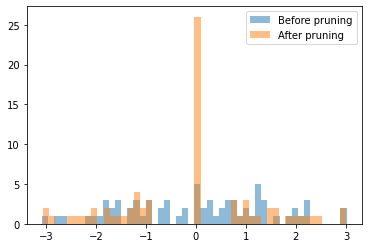

In [32]:
plt.hist(params_before_prune, bins=50, alpha=0.5, label='Before pruning')
plt.hist(params_after_prune, bins=50, alpha=0.5, label='After pruning')
plt.legend()
plt.show()

*pruning ratio* of the parameters are zero after pruning.

Circuit depth: 7
Architecture:


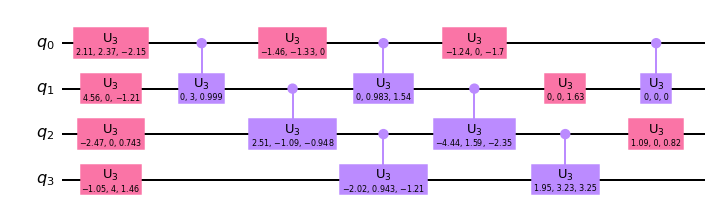

In [33]:
circ = tq2qiskit(tq.QuantumDevice(n_wires=model.n_wires), model2.q_layer)
print("Circuit depth: {0}".format(circ.depth()))
print("Architecture:")
circ.draw('mpl')


###Part 3: Evaluate the best gene on real QC

Evaluate our searched gene with pruned parameters on real quantum computers.

In [34]:
processor_real_qc = QiskitProcessor(use_real_qc=True, noise_model_name = 'ibmq_quito', backend_name='ibmq_quito')

model = model2

model.set_qiskit_processor(processor_real_qc)

evaluate_gene(gene=gene, use_qiskit=True)

ibmqfactory.load_account:WARNING:2022-09-19 00:59:26,608: Credentials are already in use. The existing account in the session will be replaced.

  0%|          | 0/2 [00:00<?, ?it/s][2022-09-19 00:59:29.915] Before transpile: {'depth': 12, 'size': 35, 'width': 8, 'n_single_gates': 24, 'n_two_gates': 7, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 8, 'rz': 4, 'rx': 4, 'u3': 8, 'cu3': 7, 'measure': 4}}
[2022-09-19 00:59:30.004] After transpile: {'depth': 59, 'size': 135, 'width': 9, 'n_single_gates': 119, 'n_two_gates': 12, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 46, 'rz': 73, 'cx': 12, 'measure': 4}}
Process ForkPoolWorker-317:
Process ForkPoolWorker-316:
Process ForkPoolWorker-318:
Process ForkPoolWorker-319:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local

KeyboardInterrupt: ignored

## 2.2 QuantumNAT: Noise Aware Param Training

In [35]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import argparse

import torchquantum as tq
import torchquantum.functional as tqf

from torchquantum.datasets import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchquantum.plugins import tq2qiskit, qiskit2tq
from torchquantum.utils import (build_module_from_op_list,
                                build_module_op_list,
                                get_v_c_reg_mapping,
                                get_p_c_reg_mapping,
                                get_p_v_reg_mapping,
                                get_cared_configs)

from torchquantum.plugins import QiskitProcessor

import random
import numpy as np

In [36]:
class QFCModel(tq.QuantumModule):
    class QLayer(tq.QuantumModule):
        def __init__(self):
            super().__init__()
            self.n_wires = 4
            self.random_layer = tq.RandomLayer(n_ops=50,
                                               wires=list(range(self.n_wires)))

            # gates with trainable parameters
            self.rx0 = tq.RX(has_params=True, trainable=True)
            self.ry0 = tq.RY(has_params=True, trainable=True)
            self.rz0 = tq.RZ(has_params=True, trainable=True)
            self.crx0 = tq.CRX(has_params=True, trainable=True)

        @tq.static_support
        def forward(self, q_device: tq.QuantumDevice):
            self.q_device = q_device

            self.random_layer(self.q_device)

            # some trainable gates (instantiated ahead of time)
            self.rx0(self.q_device, wires=0)
            self.ry0(self.q_device, wires=1)
            self.rz0(self.q_device, wires=3)
            self.crx0(self.q_device, wires=[0, 2])

            # add some more non-parameterized gates (add on-the-fly)
            tqf.hadamard(self.q_device, wires=3, static=self.static_mode,
                         parent_graph=self.graph)
            tqf.sx(self.q_device, wires=2, static=self.static_mode,
                   parent_graph=self.graph)
            tqf.cnot(self.q_device, wires=[3, 0], static=self.static_mode,
                     parent_graph=self.graph)

    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            tq.encoder_op_list_name_dict['4x4_ryzxy'])

        self.q_layer = self.QLayer()
        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 16)

        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(self.q_device, x)
            self.q_layer(self.q_device)
            x = self.measure(self.q_device)

        x = x.reshape(bsz, 2, 2).sum(-1).squeeze()
        x = F.log_softmax(x, dim=1)

        return x

def train(dataflow, model, device, optimizer):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)

        outputs = model(inputs)
        loss = F.nll_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['digit'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)

            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")


In [40]:
def main():
    n_epochs = 20

    seed = 0
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    dataset = MNIST(
        root='./mnist_data',
        train_valid_split_ratio=[0.9, 0.1],
        digits_of_interest=[3, 6],
        n_test_samples=75,
    )
    dataflow = dict()

    for split in dataset:
        sampler = torch.utils.data.RandomSampler(dataset[split])
        dataflow[split] = torch.utils.data.DataLoader(
            dataset[split],
            batch_size=256,
            sampler=sampler,
            num_workers=8,
            pin_memory=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    model = QFCModel().to(device)

    # noise_model_tq = builder.make_noise_model_tq()

    from qiskit import IBMQ
    IBMQ.load_account()

    circ = tq2qiskit(model.q_device, model.q_layer)
    """
    add measure because the transpile process may permute the wires, 
    so we need to get the final q reg to c reg mapping 
    """
    circ.measure_all()
    processor = QiskitProcessor(use_real_qc=True,
                                        backend_name='ibmq_quito')

    circ_transpiled = processor.transpile(circs=circ)
    q_layer = qiskit2tq(circ=circ_transpiled)

    model.measure.set_v_c_reg_mapping(
        get_v_c_reg_mapping(circ_transpiled))
    model.q_layer = q_layer

    noise_model_tq = tq.NoiseModelTQ(
        noise_model_name='ibmq_quito',
        n_epochs=n_epochs,
        noise_total_prob=0.5,
        # ignored_ops=configs.trainer.ignored_noise_ops,
        factor=0.1,
        add_thermal=True
    )

    noise_model_tq.is_add_noise = True

    noise_model_tq.v_c_reg_mapping = get_v_c_reg_mapping(
        circ_transpiled)
    noise_model_tq.p_c_reg_mapping = get_p_c_reg_mapping(
        circ_transpiled)
    noise_model_tq.p_v_reg_mapping = get_p_v_reg_mapping(
        circ_transpiled)
    model.set_noise_model_tq(noise_model_tq)

    optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

    for epoch in range(1, n_epochs + 1):
        # train
        print(f"Epoch {epoch}:")
        train(dataflow, model, device, optimizer)
        print(optimizer.param_groups[0]['lr'])

        # valid
        valid_test(dataflow, 'valid', model, device)
        scheduler.step()

    # test
    valid_test(dataflow, 'test', model, device, qiskit=False)

    # run on Qiskit simulator and real Quantum Computers

    # firstly perform simulate
    print(f"\nTest with Qiskit Simulator")
    processor_simulation = QiskitProcessor(use_real_qc=False)
    model.set_qiskit_processor(processor_simulation)
    valid_test(dataflow, 'test', model, device, qiskit=True)


In [42]:
main()

[2022-09-19 01:11:22.654] Only use the front 75 images as TEST set.
ibmqfactory.load_account:WARNING:2022-09-19 01:11:23,022: Credentials are already in use. The existing account in the session will be replaced.


KeyboardInterrupt: ignored

##2.3 Quantum On-Chip Training

###Part1: Parameter shift rule

####Part 1.1: Build a quantum model
Our 4-qubit quantum model contains an encoder that can encode a 4x4 image to quantum state; a quantum layer RZZ+RY+RZZ+RY, 16 parameters in total; and PauliZ measure on each qubit.

In [46]:
from torchquantum.layers import SethLayer0
class QFCModel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder(
            tq.encoder_op_list_name_dict['4x4_ryzxy'])

        self.arch = {'n_wires': self.n_wires, 'n_blocks': 2, 'n_layers_per_block': 2}
        self.q_layer = SethLayer0(self.arch)

        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        x = F.avg_pool2d(x, 6).view(bsz, 16)

        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(self.q_device, x)
            self.q_layer(self.q_device)
            x = self.measure(self.q_device)

        x = x.reshape(bsz, 4)

        return x

####Part 1.2: Build the function of parameters shift rules

The function can shift the parameters and calculate the gradients to the expectation value of each measure for each parameter. It returns both the expectaion values and the gradient for each parameter.

In [47]:
def shift_and_run(model, inputs, use_qiskit=False):
    param_list = []
    for param in model.parameters():
        param_list.append(param)
    grad_list = []
    for param in param_list:
        param.copy_(param + np.pi * 0.5)
        out1 = model(inputs, use_qiskit)
        param.copy_(param - np.pi)
        out2 = model(inputs, use_qiskit)
        param.copy_(param + np.pi * 0.5)
        grad = 0.5 * (out1 - out2)
        grad_list.append(grad)
    return model(inputs, use_qiskit), grad_list

Set whether using gpu, using cuda, number of epochs, optimizer and scheduler. Initialize the model and the MNIST-36 classification dataset.

In [53]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = QFCModel().to(device)
n_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=[3, 6],
    n_test_samples=3000,
    n_train_samples=5000
)

dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=256,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

[2022-09-19 01:20:28.490] Only use the front 5000 images as TRAIN set.
[2022-09-19 01:20:28.595] Only use the front 3000 images as TEST set.
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


####Part 1.3: Train the model.

During each training step, we calculated the gradients twice. First we use back propagation and second we use parameters shift rules.

In [54]:
grads_bp = []
grads_ps = []

def train_and_return_grad(dataflow, model, device, optimizer):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)
        
        # calculate gradients via back propagation
        outputs = model(inputs)
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        grad_bp = []
        for i, param in enumerate(model.q_layer.parameters()):
            grad_bp.append(param.grad.item())

        # calculate gradients via parameters shift rules
        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs)
        outputs.requires_grad=True
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        grad_ps = []
        for i, param in enumerate(model.q_layer.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
            grad_ps.append(param.grad.item())

        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')
        grads_bp.append(grad_bp)
        grads_ps.append(grad_ps)

def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['digit'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)
            prediction = F.log_softmax(outputs.reshape(-1, 2, 2).sum(-1).squeeze(), dim=1)

            target_all.append(targets)
            output_all.append(prediction)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")


In [55]:
for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train_and_return_grad(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])
    # valid
    valid_test(dataflow, 'valid', model, device)
    scheduler.step()

# test
valid_test(dataflow, 'test', model, device, qiskit=False)

Epoch 1:
0.005
valid set accuracy: 0.41161825726141077
valid set loss: 0.7595870494842529
Epoch 2:
0.0045225424859373685
valid set accuracy: 0.42738589211618255
valid set loss: 0.725669264793396
Epoch 3:
0.0032725424859373683
valid set accuracy: 0.4887966804979253
valid set loss: 0.7082554697990417
Epoch 4:
0.0017274575140626314
valid set accuracy: 0.5170124481327801
valid set loss: 0.6998896598815918
Epoch 5:
0.0004774575140626316
valid set accuracy: 0.5269709543568465
valid set loss: 0.6975667476654053
test set accuracy: 0.5248983739837398
test set loss: 0.7002114057540894


####Part 1.4: Plot and compare the gradients

We have recorded two sets of gradients calculated by back propagation and parameters shift rules respectively. Now let's plot these gradients and we can valid that the gradients calculated by parameters shift rules are exactly the same as those calculated by back propagation. 

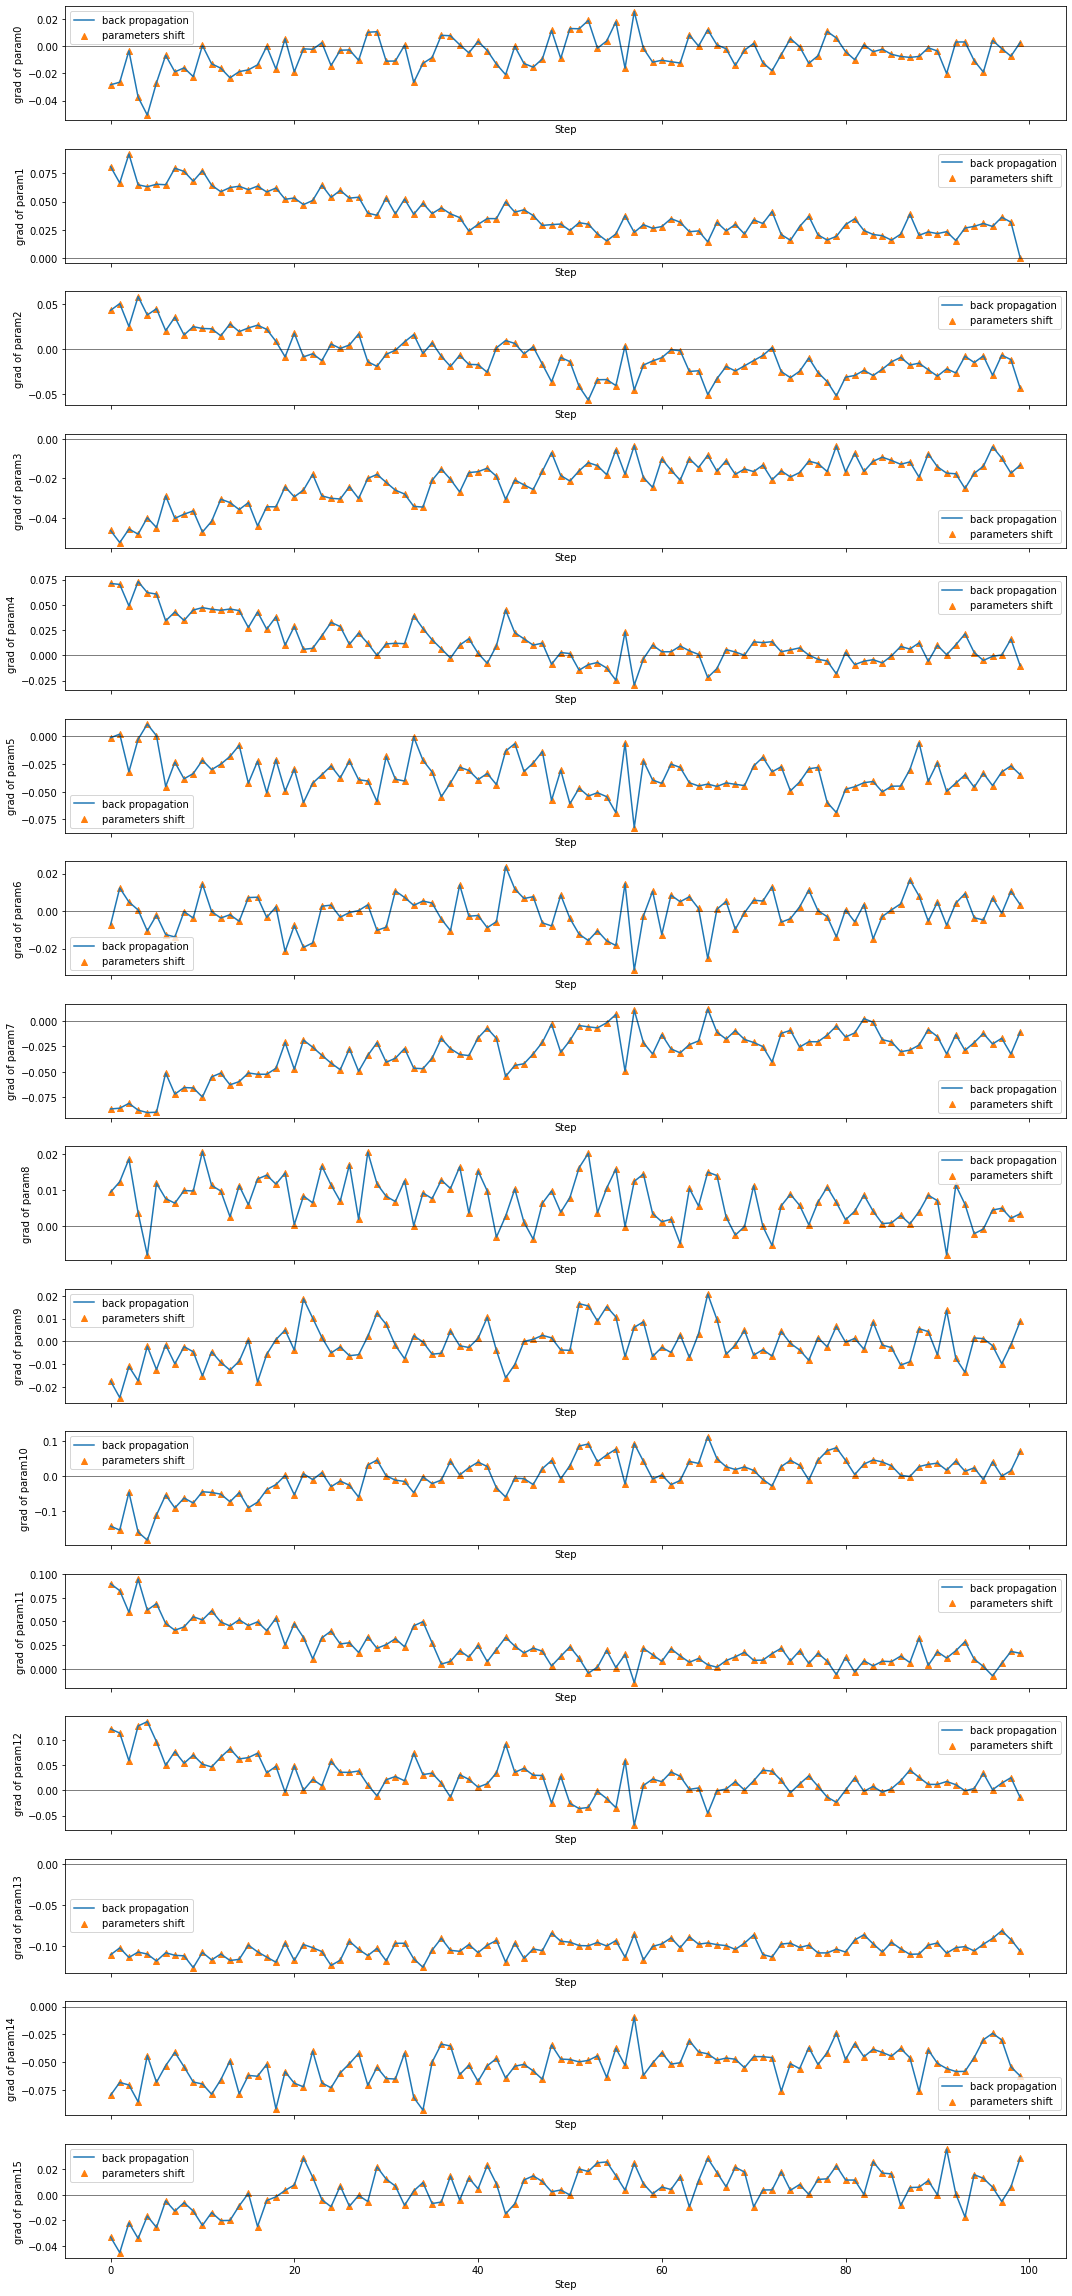

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

grads_bp = np.array(grads_bp)
grads_ps = np.array(grads_ps)

n_steps = grads_bp.shape[0]
n_params = grads_bp.shape[1]

fig, ax_list = plt.subplots(n_params, 1, sharex=True, figsize=(15, 2 * n_params))

for i, ax in enumerate(ax_list):
  ax.plot(grads_bp[:, i], c="#1f77b4", label="back propagation")
  ax.scatter(range(n_steps), grads_ps[:, i], c="#ff7f0e", marker="^", label="parameters shift")
  ax.set_ylabel("grad of param{0}".format(i))
  ax.set_xlabel("Step")
  ax.legend()
  ax.axhline(color='black', lw=0.5)

plt.tight_layout()
plt.show()


###Part 2: A simple 2 qubit model for a simple 2 classification task

Firstly we create a dataset. The dataset is a simple 2 classification dataset from [Jiang et al. (2020)](https://arxiv.org/pdf/2006.14815.pdf).

<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/2cls.png?raw=true" alt="conv-full-layer" width="200">
</div>

In [57]:
from torchpack.datasets.dataset import Dataset

class Classification2Dataset(torch.utils.data.Dataset):
    def __init__(self, num=11):
        self.data = []
        self.target = []
        sum0 = 0
        sum1 = 0
        for x in np.linspace(0, 1, num=num):
            for y in np.linspace(0, 1, num=num):
                self.data.append(torch.tensor([x, y]))
                if (x**2 + y**2 <= 0.55**2 or (x-1)**2 + (y-1)**2 <= 0.55**2):
                    self.target.append(1)
                    sum1 = sum1 + 1
                else:
                    self.target.append(0)
                    sum0 = sum0 + 1
            print(self.target[-num:])

    def __getitem__(self, idx):
        return {'data': self.data[idx], 'target': self.target[idx]}

    def __len__(self):
        return len(self.target) - 1

class Simple2Class(Dataset):
    def __init__(self):
        train_dataset = Classification2Dataset()
        valid_dataset = Classification2Dataset(num=10)
        datasets = {'train': train_dataset, 'valid': valid_dataset, 'test': valid_dataset}
        super().__init__(datasets)


Then we create our quantum circuit
<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/q2model.png?raw=true" alt="conv-full-layer" width="400">
</div>

The circuit only contains three trainable parameters. When executing the model, we firstly transform the input (x, y) to the phase $\arcsin(\sqrt{x+y-xy})$ and feed the phase to an RY gate. This is the encoding. After the ansatz, the 2 expectation values from 2 measures are the circuit outputs. Outside the circuit, we add a logsoftmax function to the output and get the predictions of each class.

In [58]:
class Q2Model(tq.QuantumModule):
    class Ansatz(tq.QuantumModule):
        def __init__(self):
            super().__init__()
            self.n_wires = 2
            self.op1 = tq.RZ(has_params=True, trainable=True)
            self.op2 = tq.RY(has_params=True, trainable=True)
            self.op3 = tq.RY(has_params=True, trainable=True)
            self.op4 = tq.CNOT(has_params=False, trainable=False)
        
        def forward(self, q_device: tq.QuantumDevice):
            self.q_device = q_device
            self.op1(self.q_device, wires=0)
            self.op2(self.q_device, wires=1)
            self.op3(self.q_device, wires=0)
            self.op4(self.q_device, wires=[0, 1])

    def __init__(self):
        super().__init__()
        self.n_wires = 2
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder([{'input_idx': [0], 'func': 'ry', 'wires': [0]}])

        self.ansatz = self.Ansatz()

        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        data = 2 * torch.arcsin(torch.sqrt(x[:, 0] + x[:, 1] - 2 * x[:, 0] * x[:, 1])).reshape(bsz, 1)

        if use_qiskit:
            data = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.ansatz, self.measure, data)
        else:
            self.encoder(self.q_device, data)
            self.ansatz(self.q_device)
            data = self.measure(self.q_device)

        data = data.reshape(bsz, 2)

        return data



Load the dataset.

In [59]:
dataset = Simple2Class()
dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Define train and valid function. The model is a 2-qubit model so there is a slightly difference to the process of the circuit output.

In [60]:
def train_2qubit(dataflow, model, device, optimizer, qiskit=False, input_name = 'data', target_name = 'target'):
    for feed_dict in dataflow['train']:
        inputs = feed_dict[input_name].to(device)
        targets = feed_dict[target_name].to(device)

        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs, use_qiskit=qiskit)
        outputs.requires_grad=True
        prediction = F.log_softmax(outputs, dim=1)
        loss = F.nll_loss(prediction, targets)
        optimizer.zero_grad()
        loss.backward()
        for i, param in enumerate(model.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test_2qubit(dataflow, split, model, device, qiskit=False, input_name = 'data', target_name = 'target'):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict[input_name].to(device)
            targets = feed_dict[target_name].to(device)

            outputs = model(inputs, use_qiskit=qiskit)
            prediction = F.log_softmax(outputs, dim=1)

            target_all.append(targets)
            output_all.append(prediction)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")


Train and valid the model on ibmq_quito. You need to import `QiskitProcessor` from `torchquantum.plugins` to create a processor that handles your access to real quantum computer. You can set whether use real quantum computer or qiskit's noise model, and the backend of your quantum computer. Call `model.set_qiskit_processor` to attach the processor to your model.

In [61]:
from torchquantum.plugins import QiskitProcessor
model = Q2Model().to(device)
processor_real_qc = QiskitProcessor(use_real_qc=True, backend_name='ibmq_quito')
model.set_qiskit_processor(processor_real_qc)

n_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=5e-2, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train_2qubit(dataflow, model, device, optimizer, qiskit=True)
    print(optimizer.param_groups[0]['lr'])
    # valid
    valid_test_2qubit(dataflow, 'valid', model, device, qiskit=True)
    scheduler.step()
# test
valid_test_2qubit(dataflow, 'test', model, device, qiskit=True)


Epoch 1:


[2022-09-19 01:21:45.229] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-09-19 01:21:45.259] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job is queued (20)    

Process ForkPoolWorker-330:
Process ForkPoolWorker-331:
Traceback (most recent call last):
Process ForkPoolWorker-328:
Process ForkPoolWorker-329:
Traceback (most recent call last):
Process ForkPoolWorker-332:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/multiprocess/process.py", line 297, in _bootstrap
    s

KeyboardInterrupt: ignored

## Tutorial *2.5*: QNN Compression

### Tutorial *2.5.1*:  LUT Construction

#### Setup

In [2]:
! pip install qiskit
! pip install pandas
! pip install torchquantum
# ! python -m pip uninstall matplotlib
! pip install matplotlib==3.1.3
!wget https://www.dropbox.com/s/qthhn8ispg631v2/model.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchquantum 0.1.2 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.


--2022-09-19 05:56:46--  https://www.dropbox.com/s/qthhn8ispg631v2/model.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/qthhn8ispg631v2/model.pth [following]
--2022-09-19 05:56:46--  https://www.dropbox.com/s/raw/qthhn8ispg631v2/model.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf0ed9989aa908b91eb0d78d643.dl.dropboxusercontent.com/cd/0/inline/BtPMhbmegT7LuFXH-Ykrkm1ny6GGuErsV6CU4ZLYmmIMHdSjOqs9yx9hcaW-qxEli7s71otg-czHJftj14-2HmhLNXHl9JWOZuSC3Y7QQf8IpG4tpk5Fz9_nprL4FstxirUTiVCJ-1OiMibfdMuipF0-1Qquxs4wGnYpuDBPc1qQPw/file# [following]
--2022-09-19 05:56:46--  https://ucf0ed9989aa908b91eb0d78d643.dl.dropboxusercontent.com/cd/0/inline/BtPMhbmegT7LuFXH-Ykrkm1ny6GGuErsV6CU4ZLYmmIMHdSjOqs9yx9hcaW-qxEli7s71otg-czHJftj14-2HmhLN

In [3]:
from qiskit import transpile 
from qiskit import QuantumCircuit
import math
import sys
from qiskit.test.mock import FakeValencia
import pandas as pd
import random
import torch
import numpy as np
import os

def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_random_seed(17)
use_cuda =  torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Tutori### LUT Construction

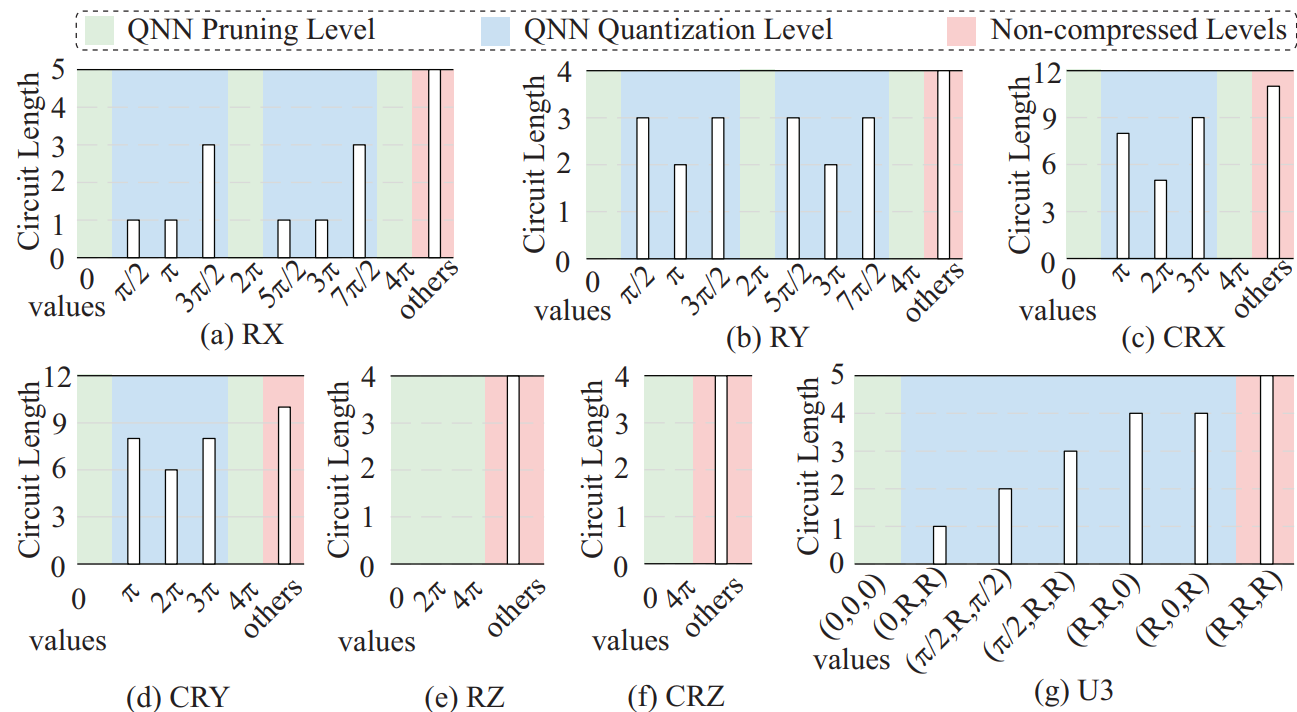

In [4]:
def LUT_construction(fixing_points,logical_gates, backend):
    head = ["fixing_points"]
    head.extend(logical_gates)
    df = pd.DataFrame(columns=head)
    for val in fixing_points:
        row = []
        row.append("{:.2f}".format(val))
        for gate in logical_gates:
            if gate in ['rx','ry','rz']:
                circ = QuantumCircuit(1, 1)
                eval('circ.{}(val,0)'.format(gate))
            if gate in ['crx','cry','crz']:
                circ = QuantumCircuit(2, 2)
                eval('circ.{}(val,0,1)'.format(gate))
            transpiled_circ = transpile(circ, backend=backend, optimization_level=2)
            depth = transpiled_circ.depth()
            row.append(depth)
        df.loc[len(df.index)] = row
    return df

#### Test Script

In [5]:
#Input
test_fixing_points = [0,math.pi*4,math.pi*2,math.pi,math.pi*3,math.pi/2,
            math.pi/2*5,math.pi/2*7,math.pi/2*3,math.pi/6]
logical_gates = ['rx','ry','rz','crx','cry','crz']
backend = FakeValencia()

#api
df = LUT_construction(test_fixing_points,logical_gates,backend)

print(df)
df.to_csv('lut.csv',)

  fixing_points rx ry rz crx cry crz
0          0.00  0  0  0   0   0   0
1         12.57  0  0  0   0   0   0
2          6.28  0  0  0   5   6   4
3          3.14  1  2  1   8   8   4
4          9.42  1  2  1   9   8   4
5          1.57  1  3  1  11  10   4
6          7.85  1  3  1  11  10   4
7         11.00  3  3  1  11  10   4
8          4.71  3  3  1  11  10   4
9          0.52  5  4  1  11  10   4


### Tutorial *2.5.2*:  LUT Reconstruction

#### Setup

In [6]:
import torchquantum as tq
import torchquantum.functional as tqf
from torch.utils.data import Dataset,DataLoader
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch

#### Generate dataset

In [7]:
def binary(input,th = 0.5):
    output = input.new(input.size())
    output[input >= th] = 1
    output[input < th] = 0
    return output

def limit(input,high = 1.0,low = 0.0):
    output = input.new(input.size())
    output = input
    output[input >= high] = high
    output[input <= low] = low
    return output
def sign(input,th = 0.5):
    output = input.new(input.size())
    output[input >= th] = 1
    output[input < th] = 0
    return output

class RandomDataset(Dataset):
    def __init__(self,sample_num,feature_num):
        if sample_num>1:
            normal_data = torch.randn(int(sample_num/2),int(feature_num/2),dtype=torch.double)
        else:
            normal_data = torch.randn(sample_num,int(feature_num/2),dtype=torch.double)
        data01 = (normal_data /16 + 0.8)*2*3.14159
        data02 = (normal_data /16 + 0.2)*2*3.14159
    
        data1 = torch.concat([data01,data02],dim=1)
        data2 = torch.concat([data02,data01],dim=1)
        if sample_num>1:
            input_data = torch.concat([data1,data2])
        else:
            input_data = data1
        self.X = limit(input_data,2*3.14159,0)
        np.random.shuffle(self.X.numpy())
        self.X = torch.tensor(self.X)
        weight1 = torch.ones(int(feature_num/2),1,dtype=torch.double)*1
        weight2 = torch.ones(int(feature_num/2),1,dtype=torch.double)*3
        weight = torch.concat([weight1,weight2])
        # print(weight)
        self.Y =torch.mm(self.X ,weight)/feature_num
        # print(self.Y)
        self.Y = sign(self.Y,th = 1*2*3.14159)


    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx][0].to(dtype=torch.int64)
        return x,y

train_db = RandomDataset(2000,16)
train_loader = DataLoader(train_db, batch_size=32, shuffle=False)
test_db = RandomDataset(1000,16)
test_loader = DataLoader(test_db, batch_size=64, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


#### Class: Build a model

In [8]:


encoding = 'angle' #'amplitude'

class QLayer18(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.layer_indexs  = dict()
        self.RYs1 = tq.Op1QAllLayer(op=tq.RY, n_wires=4,has_params=True,trainable=True)
        self.RXs1 = tq.Op1QAllLayer(op=tq.RX, n_wires=4,has_params=True,trainable=True)
        self.RZs1 = tq.Op1QAllLayer(op=tq.RZ, n_wires=4,has_params=True,trainable=True)

        self.CRYs1 = tq.Op2QAllLayer(op=tq.CRY,n_wires=4,has_params=True,trainable=True,circular =True) #Op2QAllLayer
        # self.CRXs1 = tq.Op2QAllLayer(op=tq.CRX,n_wires=4,has_params=True,trainable=True,circular =True)
        self.CRZs2 = tq.Op2QAllLayer(op=tq.CRZ,n_wires=2,has_params=True,trainable=True,circular =True)
        # self.hadmard = tq.Hadamard(n_wires=4,wires=[0, 1,2,3])
    @tq.static_support
    def forward(self, q_device: tq.QuantumDevice):
        self.q_device = q_device
        # self.hadmard(self.q_device)
        # add dense trainable gates
        self.CRZs2(self.q_device)
        self.RYs1(self.q_device)
        self.CRYs1(self.q_device)
        self.RXs1(self.q_device)
        self.RZs1(self.q_device)
        # self.CRXs1(self.q_device)
        # self.hadmard(self.q_device)



class QFCModel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        if encoding == 'angle':
            self.encoder = tq.GeneralEncoder(
                tq.encoder_op_list_name_dict['4x4_ryzxy'])
        elif encoding == 'amplitude':
            self.encoder =  tq.StateEncoder()

        self.q_layer = QLayer18()
        self.measure = tq.MeasureAll(tq.PauliZ)
        self.info =None

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        x = x.view(bsz, 16)

        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.q_layer, self.measure, x,parallel = False)
        else:
            self.encoder(self.q_device, x)
            self.q_layer(self.q_device)
            # x = self.measure(self.q_device)
        x = self.measure(self.q_device)
        x = x.reshape(bsz,2, 2).sum(-1)
        x = F.log_softmax(x, dim=1)

        return x


#### Function: Test on a dataset 

In [9]:
def test(test_loader,model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * float(correct) / float(len(test_loader.dataset))

#### Functions for LUT reconstrution

In [10]:
from qiskit.compiler.transpiler import transpile
from torchquantum.plugins import tq2qiskit, qiskit2tq
from torch.nn.parameter import Parameter

def get_weight_from_model(model):
    W =  list(model.parameters())
    W = torch.tensor(W)
    return W
def set_model_weight(model,W):
    i = 0
    for para in model.parameters():
        para.data = Parameter(torch.tensor([[W[i].data]]))
        i = i+1

def get_fixing_points_from_lut(lut):
  gates_fixing_points = list(lut['fixing_points'][:-1])
  return gates_fixing_points,len(lut)-1

def get_model_depth(q_model,backend):
  circ = tq2qiskit(tq.QuantumDevice(n_wires=q_model.n_wires), q_model, draw=True)
  transpiled_circ = transpile(circ,backend=backend)
  return transpiled_circ.depth()
  
def LUT_reconstrution(model,lut,backend,metrics_func):
  q_model = model.q_layer
  W = get_weight_from_model(q_model)
  circ = tq2qiskit(tq.QuantumDevice(n_wires=q_model.n_wires), q_model, draw=True)
  transpiled_circ = transpile(circ,backend=backend)
  original_depth = transpiled_circ.depth()
  original_acc = test(test_loader,model)

  gates_fixing_points,max_len = get_fixing_points_from_lut(lut) 
  para_acc = np.zeros([W.shape[0],max_len])
  para_depth = np.zeros_like(para_acc)
  para_metrics1 = np.zeros_like(para_acc)
  best_fixing_points =np.zeros(W.shape[0])
  
  for i in range(W.shape[0]):
    min_d_acc = 1000.0
    for j in range(max_len):
      W2 = W.clone()
      W2[i]= gates_fixing_points[j]
      set_model_weight(model,W2)
      acc2 = test( test_loader,model)
      depth2 = get_model_depth(model.q_layer,backend=backend)
      para_acc[i][j] = acc2 *1.0 /original_acc
      para_depth[i][j] = depth2 *1.0/original_depth
      para_metrics1 = metrics_func(para_acc,para_depth)
  best_index = np.argmax(para_metrics1,axis=1)
  for i in range(W.shape[0]):
    best_fixing_points[i] = gates_fixing_points[best_index[i]]
  return best_fixing_points

#### Test Script

In [11]:
#input
from qiskit.test.mock import FakeValencia

model = torch.load('model.pth')
lut = pd.read_csv('lut.csv')
def metrics_func(acc,depth):
  return acc+1.0/depth
backend = FakeValencia()


#api 
new_lut = LUT_reconstrution(model,lut,backend,metrics_func)

print(new_lut)
np.save('new_lut.npy',new_lut)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


[ 7.85  7.85 11.   12.57  9.42  7.85  9.42  3.14  9.42  1.57  0.   12.57
  0.    0.    0.    0.    9.42  0.  ]


### Tutorial *2.5.3*: ADMM Training and compression

#### Setup

In [12]:
import torchquantum as tq
import torchquantum.functional as tqf
from torch.utils.data import Dataset,DataLoader
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter



#### Class: ADMM

In [13]:
def get_fixing_parameters(weight,regu_val = 6.2831853071796 ):
    fixing_paras = torch.zeros_like(weight)
    return fixing_paras


def get_fixing_abs(weight,fix_para):
    fixing_abs= torch.abs(weight-fix_para)
    return fixing_abs


class ADMM:
    def __init__(self, model,args,rho=0.001):
        self.ADMM_U = {}
        self.ADMM_Z = {}
        self.rho = rho
        self.args =args

        self.init(model,args.prune_ratio)


    
    def get_weight_from_model(self,model):
        W =  list(model.parameters())
        W = torch.tensor(W).to(device)
        return W

    def set_model_weight(self,model,W):
        i = 0
        for para in model.parameters():
            para.data = Parameter(torch.tensor([[W[i].data]]))
            i = i+1


    def init(self, model,prune_ratio):
        self.prune_ratio = prune_ratio
        W = self.get_weight_from_model(model.q_layer)
        self.ADMM_U = torch.zeros(W.shape).to(device)  # add U
        self.ADMM_Z = torch.Tensor(W.shape).to(device)  # add Z
    
    def get_sensitive_fixing_parameters(self):
        return self.sensitive_fixing_parameters

    def set_sensitive_fixing_parameters(self,fixing_para):
        self.sensitive_fixing_parameters = fixing_para
        self.sensitive_fixing_parameters = torch.tensor(self.sensitive_fixing_parameters,dtype=torch.float)
    

    def weight_pruning(self, weight):
        prune_ratio = self.prune_ratio
        weight = weight.cpu().detach().numpy()  # convert cpu tensor to numpy
        percent = prune_ratio * 100
        weight = torch.tensor(weight)
        fixing_para = self.get_sensitive_fixing_parameters()
        weight_temp = get_fixing_abs(weight,fixing_para)
        percentile = np.percentile(weight_temp, percent)  # get a value for this percentitle
        under_threshold = weight_temp < percentile
        above_threshold = weight_temp >= percentile
        weight[under_threshold] = fixing_para[under_threshold]
        above_threshold = above_threshold.type(torch.float32)  # has to convert bool to float32 for numpy-tensor conversion
        return above_threshold.to(device), weight.to(device)



    def hard_prune(self,  model):
        """
        hard_pruning, or direct masking
        Args:
             model: contains weight tensors in cuda
    
        """
    
        print("hard pruning")
        W = self.get_weight_from_model(model.q_layer)
        cuda_pruned_weights = None
    
        mask, cuda_pruned_weights = self.weight_pruning(W)  # get sparse model in cuda
    
        W.data = cuda_pruned_weights  # replace the data field in variable
        self.set_model_weight(model,W)
        return mask



    def admm_initialization(self, model):
        if not self.args.admm:
            return
        W = self.get_weight_from_model(model.q_layer)
        _, updated_Z = self.weight_pruning(W)  # Z(k+1) = W(k+1)+U(k)  U(k) is zeros her
        self.ADMM_Z = updated_Z
    
    
    def z_u_update(self, model, epoch,  batch_idx):
        if not self.args.admm:
            return
    
        if epoch != 1 and (epoch - 1) % self.args.admm_epochs == 0 and batch_idx == 0:
    
            Z_prev = None
            W = self.get_weight_from_model(model.q_layer)
            self.ADMM_Z = W.detach() + self.ADMM_U.detach()  # Z(k+1) = W(k+1)+U[        
            _, updated_Z = self.weight_pruning(self.ADMM_Z)  # equivalent to Euclidean Projection
            self.ADMM_Z = updated_Z
            self.ADMM_U = W.detach() - self.ADMM_Z.detach() + self.ADMM_U.detach()  # U(k+1) = W(k+1) - Z(k+1) +U(k)


    def append_admm_loss(self, model, ce_loss):
        '''
        append admm loss to cross_entropy loss
        Args:
            args: configuration parameters
            model: instance to the model class
            ce_loss: the cross entropy loss
        Returns:
            ce_loss(tensor scalar): original cross enropy loss
            admm_loss(dict, name->tensor scalar): a dictionary to show loss for each layer
            ret_loss(scalar): the mixed overall loss
    
        '''
        admm_loss = {}
    
        if self.args.admm:
            W = self.get_weight_from_model(model.q_layer)
            admm_loss = 0.5 * self.rho * (torch.norm(W - self.ADMM_Z + self.ADMM_U, p=2) ** 2)
        mixed_loss = admm_loss
        mixed_loss += ce_loss
        return ce_loss, admm_loss, mixed_loss


    def admm_adjust_learning_rate(self,optimizer, epoch):
        """ (The pytorch learning rate scheduler)
    Set the learning rate to the initial LR decayed by 10 every 30 epochs"""
        """
        For admm, the learning rate change is periodic.
        When epoch is dividable by admm_epoch, the learning rate is reset
        to the original one, and decay every 3 epoch (as the default 
        admm epoch is 9)
    
        """
        admm_epoch = self.args.admm_epochs
        lr = None
        if epoch % admm_epoch == 0:
            lr = self.args.lr
        else:
            admm_epoch_offset = epoch % admm_epoch
    
            admm_step = admm_epoch / 3  # roughly every 1/3 admm_epoch.
    
            lr = self.args.lr * (0.1 ** (admm_epoch_offset // admm_step))
    
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr



class CrossEntropyLossMaybeSmooth(nn.CrossEntropyLoss):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    def __init__(self, smooth_eps=0.0):
        super(CrossEntropyLossMaybeSmooth, self).__init__()
        self.smooth_eps = smooth_eps

    def forward(self, output, target, smooth=False):
        if not smooth:
            return F.cross_entropy(output, target)

        target = target.contiguous().view(-1)
        n_class = output.size(1)
        one_hot = torch.zeros_like(output).scatter(1, target.view(-1, 1), 1)
        smooth_one_hot = one_hot * (1 - self.smooth_eps) + (1 - one_hot) * self.smooth_eps / (n_class - 1)
        log_prb = F.log_softmax(output, dim=1)
        loss = -(smooth_one_hot * log_prb).sum(dim=1).mean()
        return loss
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.view(batch_size,-1)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

#### Function: ADMM train and test

In [14]:

def train(model,train_loader,criterion, optimizer, scheduler, epoch, args,mask =None,admm_flag = True, ADMM = None ):
    losses = AverageMeter()
    top1 = AverageMeter()
    idx_loss_dict = {}

    # switch to train mode
    model.to(device)
    model.train()

    masks = mask
    for i, (input, target) in enumerate(train_loader):
       
        # adjust learning rate
        if admm_flag:
            ADMM.admm_adjust_learning_rate(optimizer, epoch)
        else:
            scheduler.step()

        input = input.to(device)
        target = target.to(device)

        # compute output
        output = model(input)


        ce_loss = criterion(output, target)

        if admm_flag:
            ADMM.z_u_update(model, epoch, i)  # update Z and U variables
            ce_loss, admm_loss, mixed_loss = ADMM.append_admm_loss(model, ce_loss)  # append admm losss

        # measure accuracy and record loss
        acc1,_ = accuracy(output, target, topk=(1,1))

        losses.update(ce_loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()

        if admm_flag:
            mixed_loss.backward()
        else:
            ce_loss.backward()

        if masks != None:
            mask_index =0
            with torch.no_grad():
                for item in model.parameters():
                    device_mask = masks[mask_index].to(device)
                    item.grad *= device_mask
                    mask_index = mask_index+1

        optimizer.step()
    return idx_loss_dict



def test(test_loader,model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    return  100. * float(correct) / float(len(test_loader.dataset))

#### Input for ADMM training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The transpiled circuit length of original model is 57
. Accuracy is 94.2


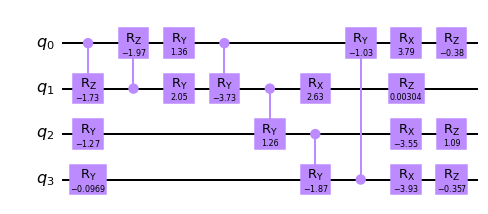

In [15]:
from qiskit.compiler.transpiler import transpile
from torchquantum.plugins import tq2qiskit, qiskit2tq
from torch.nn.parameter import Parameter
from qiskit.test.mock import FakeValencia
import matplotlib.pyplot as plt

def get_model_depth(q_model,backend):
  circ = tq2qiskit(tq.QuantumDevice(n_wires=q_model.n_wires), q_model, draw=True)
  circ.draw()
  transpiled_circ = transpile(circ,backend=backend)
  return transpiled_circ.depth()


#input
model = torch.load('model.pth')
new_lut = np.load('new_lut.npy')
new_lut = np.array(new_lut,dtype=np.float)
backend = FakeValencia()

#calculate the infomation of trained model
q_model = model.q_layer
original_depth = get_model_depth(q_model,backend)
original_acc = test(test_loader,model)
print('The transpiled circuit length of original model is {}\n. Accuracy is {}'.format(original_depth,original_acc) )

# training parameters
class Args:
  def __init__(self):
    self.admm = True
    self.masked_retrain = True
    self.rho =0.001
    self.admm_epochs = 1
    self.rho_num =1
    self.lr = 0.01
    self.epochs =10
    self.prune_ratio =  0.38

# show the trained circuit
circ = tq2qiskit(tq.QuantumDevice(n_wires=q_model.n_wires), q_model, draw=True)
transpiled_circ = transpile(circ,backend=backend)
circ.draw(output='mpl')

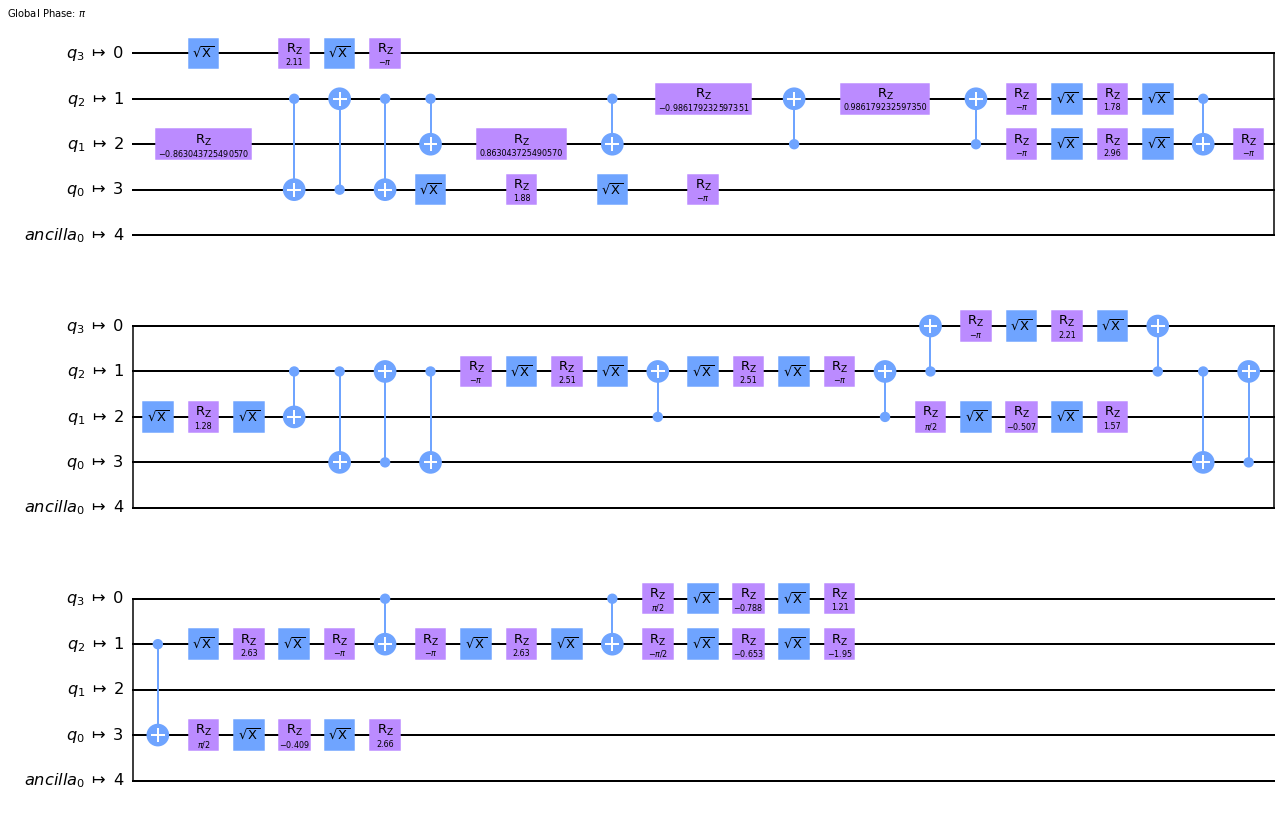

In [16]:
transpiled_circ.draw(output='mpl')

#### ADMM training

In [17]:
import argparse
import torch.optim as optim
import copy

args = Args()
criterion = torch.nn.CrossEntropyLoss()
    
    
if args.admm:
    print('*'*20 +'admm'+'*'*20)
    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    scheduler = None
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs * len(train_loader), eta_min=4e-08)
    initial_rho = args.rho
    for i in range(args.rho_num):
        current_rho = initial_rho * 10 ** i
        # print("current rho: {}".format(current_rho))
        ADMM = ADMM(model, args, rho=current_rho)
        ADMM.set_sensitive_fixing_parameters(new_lut) ### set the new lut as target for each parameter.
        ADMM.admm_initialization(model=model)  # intialize Z variabl
        # admm train
        best_prec1 = 0.
        for epoch in range(1, args.epochs + 1):
            train(model, train_loader, criterion, optimizer, scheduler, epoch, args, mask=None,admm_flag= True,ADMM= ADMM)
            prec1 = test( test_loader,model)
            best_prec1 = max(prec1, best_prec1)
            print("Best Acc: {:.4f}%".format(best_prec1))


********************admm********************
Best Acc: 95.4000%
Best Acc: 95.9000%
Best Acc: 96.1000%
Best Acc: 96.1000%
Best Acc: 96.6000%


KeyboardInterrupt: ignored

#### Masked retraining (finetuning)

********************masked_retrain********************
hard pruning


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


>_ Got better accuracy 92.600% now...
Best Acc: 92.6000% , Best Depth: 37


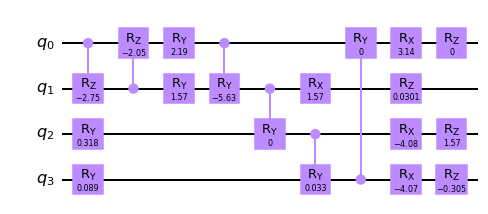

In [ ]:
if args.masked_retrain:
    print('*'*20 +'masked_retrain'+'*'*20)
    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    scheduler = None
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs * len(train_loader), eta_min=4e-08)
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    masks = ADMM.hard_prune(model)
    epoch_loss_dict = {}
    testAcc = []
    testDepth = []
    best_prec1 = 0
    best_depth1 = 0
    best_metrics1 =[0]
    for epoch in range(1, args.epochs + 1):
        idx_loss_dict = train(model, train_loader, criterion, optimizer, scheduler, epoch, args,mask = masks,admm_flag=False)
        prec1 = test(test_loader,model)
        temp_model  = copy.deepcopy(model)
        depth1 = get_model_depth(temp_model.q_layer,backend) 
        prec_norm = prec1*1.0/original_acc
        depth_norm =depth1*1.0/original_depth
        para_metrics1 = prec_norm + 1.0/depth_norm
        if para_metrics1 > max(best_metrics1):
            best_model = copy.deepcopy(model)
            best_prec1 = prec1
            best_depth1 = depth1
            print(">_ Got better accuracy {:.3f}% now...".format(prec1))
        epoch_loss_dict[epoch] = idx_loss_dict
        testAcc.append(prec1)
        testDepth.append(depth1)
        best_metrics1.append(para_metrics1)
    print("Best Acc: {:.4f}% , Best Depth: {:d}".format(best_prec1,best_depth1))
    # print('testAcc:',testAcc)
    # print('testDepth:',testDepth)
q_model = best_model.q_layer
circ = tq2qiskit(tq.QuantumDevice(n_wires=q_model.n_wires), q_model, draw=True)
transpiled_circ = transpile(circ,backend=backend)
circ.draw(output='mpl')

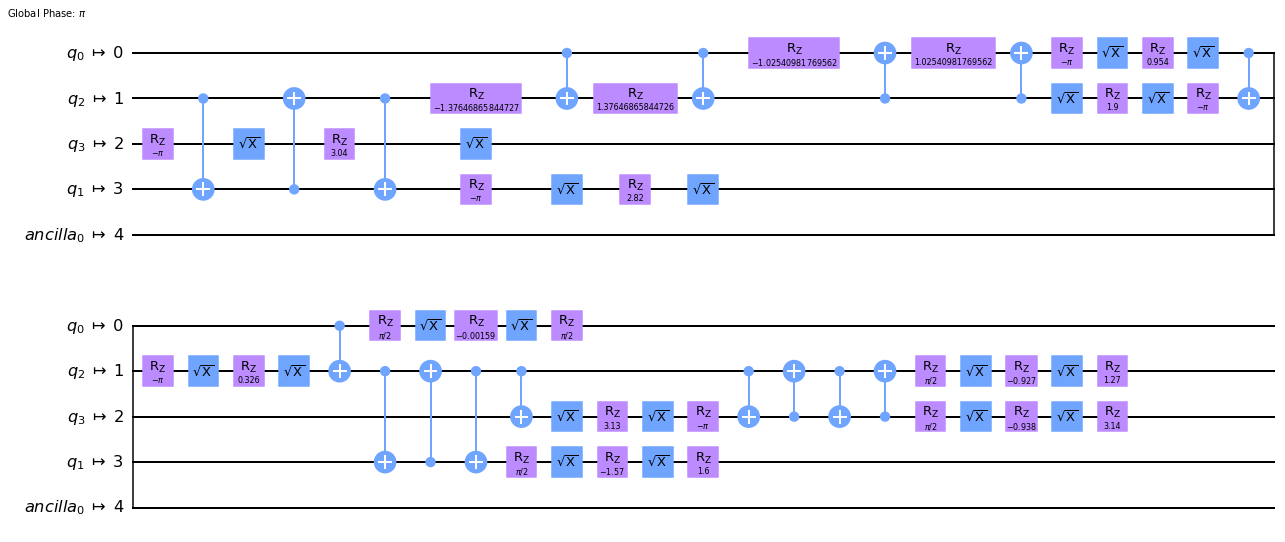

In [ ]:
transpiled_circ.draw(output='mpl')